**Asignatura**: SNS  

**Número de actividad**: ACTIVIDAD_3_7

**Fecha**: 26/03/2025  

**Alumno**: Pedro García Ramírez   

# Actividad 3.7: Predicción de Riesgo de Derrumbamiento en Terremotos

En este notebook se aborda el problema de predecir el nivel de daño en edificaciones tras un terremoto.  
El objetivo es desarrollar modelos de machine learning que, a partir de las características de los edificios y el entorno,
predigan el riesgo de derrumbamiento (1: Daño leve, 2: Daño medio, 3: Destrucción completa).

Para ello, se implementarán:
- Modelos basados en árboles (Decision Tree, Random Forest, Gradient Boosting).
- Un modelo basado en SVM.
- Optimización de hiperparámetros mediante GridSearchCV y RandomizedSearchCV.
- Análisis exploratorio con técnicas como dendrogramas para la selección de características.
- Evaluación preliminar de distintos modelos usando Lazy Predict.

La metodología se centra en la justificación de cada paso, tanto en la selección de datos como en la configuración de los modelos,
con el fin de obtener resultados sólidos y reproducibles.


# 1.- Importación del dataset y preparación de los datos / Normalización y limpieza

## Paso 1: Importación de Librerías y Configuración del Entorno

En esta sección se importan todas las librerías necesarias para el desarrollo del proyecto,
como `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn` y `Lazy Predict`.  
También se configuran los estilos para las visualizaciones.


In [ ]:
# ===============================
# IMPORTACIÓN DE LIBRERÍAS
# ===============================

# -------------------------------------
# MANEJO DE DATOS
# -------------------------------------
import pandas as pd                      # Librería principal para manipulación y análisis de datos en estructuras tipo DataFrame.
import numpy as np                       # Soporte para arrays, operaciones matemáticas y álgebra lineal.

# -------------------------------------
# VISUALIZACIÓN DE DATOS
# -------------------------------------
import matplotlib.pyplot as plt          # Visualización estática en gráficos 2D (histogramas, curvas, etc.).
import seaborn as sns                    # Librería basada en matplotlib para visualizaciones estadísticas más atractivas y fáciles.

# -------------------------------------
# CLUSTERING JERÁRQUICO
# -------------------------------------
import scipy.cluster.hierarchy as sch    # Herramientas para realizar y visualizar dendrogramas de clustering jerárquico.

# -------------------------------------
# CONTROL DE TIEMPO
# -------------------------------------
import time                              # Utilidad estándar para medir tiempos de ejecución o simular pausas.

# ===============================
# BIBLIOTECAS DE SKLEARN (Machine Learning)
# ===============================

# -------------------------------------
# SELECCIÓN Y EVALUACIÓN DE MODELOS
# -------------------------------------
from sklearn.model_selection import (
    train_test_split,                    # División del dataset en conjunto de entrenamiento y prueba.
    GridSearchCV,                        # Búsqueda exhaustiva de hiperparámetros con validación cruzada.
    RandomizedSearchCV,                  # Búsqueda aleatoria de hiperparámetros (más rápida que GridSearchCV).
    cross_val_score,                     # Evaluación de modelos mediante validación cruzada.
    StratifiedKFold,                     # Validación cruzada estratificada para clasificación con clases desbalanceadas.
    ParameterSampler                     # Generador de combinaciones de hiperparámetros aleatorias.
)

# -------------------------------------
# MÉTRICAS DE EVALUACIÓN
# -------------------------------------
from sklearn.metrics import (
    f1_score,                            # Métrica de evaluación que combina precisión y exhaustividad (media armónica).
    make_scorer,                         # Permite crear funciones de scoring personalizadas.
    confusion_matrix,                    # Matriz de confusión para evaluar el rendimiento del modelo.
    classification_report,               # Reporte completo con precisión, recall, f1-score y soporte.
    roc_curve,                           # Curva ROC para evaluar la capacidad de discriminación binaria.
    auc                                  # Área bajo la curva ROC.
)

# -------------------------------------
# ALGORITMOS DE CLASIFICACIÓN
# -------------------------------------
from sklearn.tree import DecisionTreeClassifier      # Árbol de decisión como modelo base interpretable.
from sklearn.ensemble import (
    RandomForestClassifier,                          # Ensamble de múltiples árboles de decisión (bagging).
    GradientBoostingClassifier                       # Ensamble secuencial de árboles con mejora de gradiente (boosting).
)
from sklearn.svm import SVC                          # Máquina de vectores de soporte (SVM), útil para problemas no lineales.

# -------------------------------------
# PREPROCESADO Y SELECCIÓN DE VARIABLES
# -------------------------------------
from sklearn.preprocessing import (
    StandardScaler,                    # Estandarización de características (media = 0, desviación estándar = 1).
    label_binarize                     # Conversión de etiquetas en formato multiclase binarizado (para curvas ROC).
)
from sklearn.feature_selection import (
    SelectKBest,                       # Selección de las K mejores características.
    mutual_info_classif                # Criterio de información mutua para selección de variables en clasificación.
)

# -------------------------------------
# BARRA DE PROGRESO
# -------------------------------------
from tqdm import tqdm                  # Progreso visual en bucles (loops de entrenamiento largos).

# -------------------------------------
# AUTOMATIZACIÓN DE MODELOS SUPERVISADOS
# -------------------------------------
from lazypredict.Supervised import LazyClassifier   # Automatiza el entrenamiento y comparación de múltiples clasificadores.

# ===============================
# CONFIRMACIÓN FINAL
# ===============================
print("\nLibrerías importadas correctamente.")



Librerías importadas correctamente.


## Paso 2: Importación y Preparación de los Datos

En esta sección, realizamos el **preprocesamiento completo de los datos** para entrenar un modelo de clasificación robusto y confiable. Este proceso es **fundamental en cualquier proyecto de Machine Learning**, ya que la calidad del modelo está directamente relacionada con la calidad de los datos de entrada.

A continuación, se describen las etapas clave que abordamos:

###  1. Carga de datos
Importamos los datasets directamente desde GitHub. Esto incluye:
- `train_values`: contiene las características del conjunto de entrenamiento.
- `train_labels`: contiene la variable objetivo (`damage_grade`).
- `test_values`: contiene las características del conjunto de prueba (sin etiquetas).

###  2. Unión de datos
Combinamos `train_values` y `train_labels` utilizando `building_id` como clave para obtener un único DataFrame consolidado (`train_data`).

###  3. Limpieza y calidad de los datos
- Eliminamos duplicados para evitar sesgo o sobreajuste.
- Identificamos y rellenamos valores nulos en columnas numéricas usando la **media** de cada columna.
- Eliminamos columnas irrelevantes como `building_id` que no aportan valor predictivo.

###  4. Codificación de variables categóricas
Transformamos las columnas categóricas usando **One-Hot Encoding**, permitiendo que los modelos numéricos las interpreten correctamente. Se elimina la primera categoría de cada variable para evitar colinealidad (opción `drop_first=True`).

###  5. Normalización de variables numéricas
Aplicamos `StandardScaler` para estandarizar las características numéricas a una media de 0 y desviación estándar de 1. Esto mejora el rendimiento de algoritmos sensibles a la escala, como SVM.

###  6. Preprocesamiento del conjunto de test
Repetimos el preprocesamiento en `test_values`:
- Se eliminan columnas no predictoras.
- Se codifican las variables categóricas.
- Se **alinean las columnas** con el conjunto de entrenamiento (si faltan columnas, se rellenan con ceros).
- Se normalizan las columnas numéricas con el **mismo escalador** del entrenamiento.

Finalmente, se construyen los DataFrames `train_data_scaled` y `test_data_final`, completamente listos para:
- Entrenar modelos.
- Validar rendimiento.
- Realizar predicciones.

⚠️ **Nota**: Se conserva `building_id` en el conjunto de test para poder identificar los registros al momento de generar el archivo de predicciones.






In [ ]:
# ----------------------------------------------------------------------
# 1. IMPORTACIÓN DE DATOS DESDE GITHUB (PODRÍA SER TAMBIÉN DESDE DRIVE)
# ----------------------------------------------------------------------

# URL de los archivos CSV alojados en GitHub
train_values_url = "https://raw.githubusercontent.com/pegaram/SMS_ACT3_7/refs/heads/main/data/train_values.csv"
train_labels_url = "https://raw.githubusercontent.com/pegaram/SMS_ACT3_7/refs/heads/main/data/train_labels.csv"
test_values_url  = "https://raw.githubusercontent.com/pegaram/SMS_ACT3_7/refs/heads/main/data/test_values.csv"

# Lectura de los archivos CSV en DataFrames de pandas
train_values = pd.read_csv(train_values_url)   # Características de entrenamiento
train_labels = pd.read_csv(train_labels_url)   # Etiquetas (clase objetivo) de entrenamiento
test_values  = pd.read_csv(test_values_url)    # Características del conjunto de test

# Mostrar las dimensiones de cada conjunto para comprobar que los datos se han cargado correctamente
print("Dimensiones de train_values:", train_values.shape)
print("Dimensiones de train_labels:", train_labels.shape)
print("Dimensiones de test_values:", test_values.shape)


# ----------------------------------------------------------------------
# 2. UNIÓN DE CARACTERÍSTICAS Y ETIQUETAS EN UN SOLO DATAFRAME
# ----------------------------------------------------------------------

# La clave común para unir ambos DataFrames es 'building_id'
train_data = pd.merge(train_values, train_labels, on='building_id')

# Confirmar el resultado de la unión
print("\nDimensiones de train_data (unión de train_values y train_labels):", train_data.shape)


# ----------------------------------------------------------------------
# 3. AJUSTE DE CALIDAD DE DATOS EN train_data
# ----------------------------------------------------------------------

# a) Eliminar filas duplicadas si existen
initial_size = train_data.shape[0]  # Guardamos el número original de filas
train_data.drop_duplicates(inplace=True)  # Elimina duplicados directamente en el DataFrame
print(f"\nEliminadas {initial_size - train_data.shape[0]} filas duplicadas.")

# b) Comprobar valores nulos en las columnas
null_counts = train_data.isnull().sum()  # Cuenta de valores nulos por columna
print("\nValores nulos por columna (train_data):")
print(null_counts[null_counts > 0])  # Mostrar solo columnas con valores nulos

# c) Imputar valores nulos en columnas numéricas usando la media de la columna
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    train_data[col].fillna(train_data[col].mean(), inplace=True)  # Imputación in-place

# d) Eliminar columnas que no son predictoras (como IDs)
if 'building_id' in train_data.columns:
    train_data.drop(columns=['building_id'], inplace=True)


# ----------------------------------------------------------------------
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# ----------------------------------------------------------------------

# Identificar columnas categóricas (tipo 'object')
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Aplicar codificación One-Hot solo si existen columnas categóricas
# drop_first=True elimina una de las clases para evitar multicolinealidad
if categorical_cols:
    train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)


# ----------------------------------------------------------------------
# 5. NORMALIZACIÓN DE COLUMNAS NUMÉRICAS
# ----------------------------------------------------------------------

# Separar la variable objetivo ('damage_grade') del resto de características
label_col = 'damage_grade'
if label_col in train_data.columns:
    y = train_data[label_col]  # Variable dependiente
    X = train_data.drop(columns=[label_col])  # Variables independientes
else:
    # Mensaje de advertencia si no se encuentra la variable objetivo
    print(f"La columna {label_col} no existe. Revisa el nombre de la variable objetivo.")
    X = train_data.copy()
    y = None

# Recalcular columnas numéricas por si hubo cambios tras codificación
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Inicializar el escalador
scaler = StandardScaler()

# Crear una copia del conjunto de entrenamiento para normalizar
X_scaled = X.copy()

# Normalizar las columnas numéricas (media = 0, desviación estándar = 1)
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Reconstruir el DataFrame final uniendo las variables escaladas y la etiqueta
train_data_scaled = pd.concat([X_scaled, y], axis=1)

# Mostrar forma final del DataFrame y una muestra de sus datos
print("\nDimensiones de train_data_scaled:", train_data_scaled.shape)
print("Primeras filas del DataFrame escalado:")
display(train_data_scaled.head())


# ----------------------------------------------------------------------
# 6. PREPROCESAMIENTO DEL CONJUNTO DE TEST
# ----------------------------------------------------------------------

# Guardar los IDs del conjunto de test (para el archivo final de predicciones)
test_ids = test_values['building_id']

# Eliminar 'building_id' del conjunto de test (no es predictor)
if 'building_id' in test_values.columns:
    test_data = test_values.drop(columns=['building_id'])
else:
    test_data = test_values.copy()

# Aplicar codificación One-Hot al conjunto de test (igual que en entrenamiento)
test_data = pd.get_dummies(test_data, drop_first=True)

# Alinear las columnas del test con las del conjunto de entrenamiento (rellenar con ceros si falta alguna)
train_feature_cols = X_scaled.columns
test_data_aligned = test_data.reindex(columns=train_feature_cols, fill_value=0)

# Aplicar el mismo escalado a las columnas numéricas del test
test_data_aligned[numeric_cols] = scaler.transform(test_data_aligned[numeric_cols])

# Reconstruir el conjunto de test final incluyendo 'building_id'
test_data_final = pd.concat([test_ids, test_data_aligned], axis=1)

# Mostrar dimensiones y primeras filas del test procesado
print("\nDimensiones del conjunto de test procesado:", test_data_final.shape)
print("Primeras filas del conjunto de test procesado:")
display(test_data_final.head())



Dimensiones de train_values: (260601, 39)
Dimensiones de train_labels: (260601, 2)
Dimensiones de test_values: (86868, 39)

Dimensiones de train_data (unión de train_values y train_labels): (260601, 40)

Eliminadas 0 filas duplicadas.

Valores nulos por columna (train_data):
Series([], dtype: int64)

Dimensiones de train_data_scaled: (260601, 61)
Primeras filas del DataFrame escalado:


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
0,-0.98,-0.52,1.63,-0.18,0.05,-0.46,-0.23,3.21,0.56,-0.19,...,False,False,False,False,False,False,False,True,False,3
1,-0.73,0.48,-0.95,-0.18,-0.22,-0.00,0.82,-0.31,0.56,-0.19,...,False,False,False,False,False,False,False,True,False,2
2,0.88,-0.82,0.74,-0.18,-0.22,-0.69,-0.23,-0.31,0.56,-0.19,...,False,False,False,False,False,False,False,True,False,3
3,1.01,-0.69,1.22,-0.18,-0.22,-0.46,-0.23,-0.31,0.56,-0.19,...,False,False,False,False,False,False,False,True,False,2
4,-0.36,-1.38,-1.31,1.20,0.05,-0.00,1.86,3.21,-1.79,-0.19,...,False,False,False,False,False,False,False,True,False,3



Dimensiones del conjunto de test procesado: (86868, 61)
Primeras filas del conjunto de test procesado:


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,0.39,-0.25,1.38,1.20,-0.09,-0.23,0.29,-0.31,0.56,...,False,False,False,False,False,False,False,False,True,False
1,99355,-0.98,-1.36,1.57,-0.18,-0.02,1.13,-0.23,-0.31,0.56,...,False,False,False,False,False,False,False,False,True,False
2,890251,1.01,-1.65,1.04,-0.18,-0.29,-0.91,-0.23,-0.31,0.56,...,False,False,False,False,False,False,False,False,True,False
3,745817,1.51,-1.60,-1.54,-1.55,-0.36,2.50,-1.27,-0.31,-1.79,...,False,False,False,False,False,False,False,False,True,False
4,421793,0.39,-1.00,0.47,1.20,-0.16,-0.00,0.82,-0.31,0.56,...,False,False,False,False,False,False,False,False,True,False


# 2.- Selección de características

## Paso 3: Selección de características sin uso de dendogramas

En esta sección se aplican distintas técnicas de **selección de características** con el objetivo de reducir la dimensionalidad del dataset, eliminar variables redundantes y conservar únicamente aquellas que aportan **mayor valor predictivo** al modelo. El proceso se divide en cuatro fases:

---

###  1. Identificación de Variables Numéricas
Se seleccionan únicamente las columnas de tipo numérico, excluyendo explícitamente la variable objetivo (`damage_grade`), ya que no debe ser tratada como predictor en los análisis posteriores.

---

###  2. Análisis de Correlación entre Variables
Se calcula la **matriz de correlación de Pearson** entre todas las variables numéricas. Esta matriz se visualiza mediante un **mapa de calor** para identificar fácilmente patrones de alta correlación.

- Se define un **umbral de correlación** (0.85).
- Se eliminan aquellas variables que están altamente correlacionadas con otras para evitar **redundancia** y **multicolinealidad**, lo cual puede afectar negativamente al entrenamiento del modelo.

---

###  3. Evaluación de Importancia con Random Forest
Se entrena un modelo **Random Forest** para medir la **importancia relativa** de cada variable. Esta técnica permite:

- Identificar qué variables contribuyen más a la predicción del modelo.
- Obtener una **clasificación automática** de las variables en función de su relevancia.
- Visualizar el **Top 10** de variables más importantes mediante un gráfico de barras.

---

###  4. Selección Univariante con SelectKBest
Se aplica el método `SelectKBest` junto con `mutual_info_classif`, una técnica estadística que mide la **información mutua** entre cada predictor y la variable objetivo:

- Se conservan las **K mejores variables** (en este caso, 10), es decir, las que presentan una mayor relación individual con la etiqueta.
- Este método es útil cuando se busca una evaluación rápida y cuantitativa del poder predictivo individual de cada variable.

---

⚠️ **Nota:** Esta combinación de técnicas (correlación, modelos de árbol e información mutua) permite tomar decisiones fundamentadas sobre qué variables conservar, facilitando modelos más simples, rápidos y eficientes, sin pérdida significativa de rendimiento.





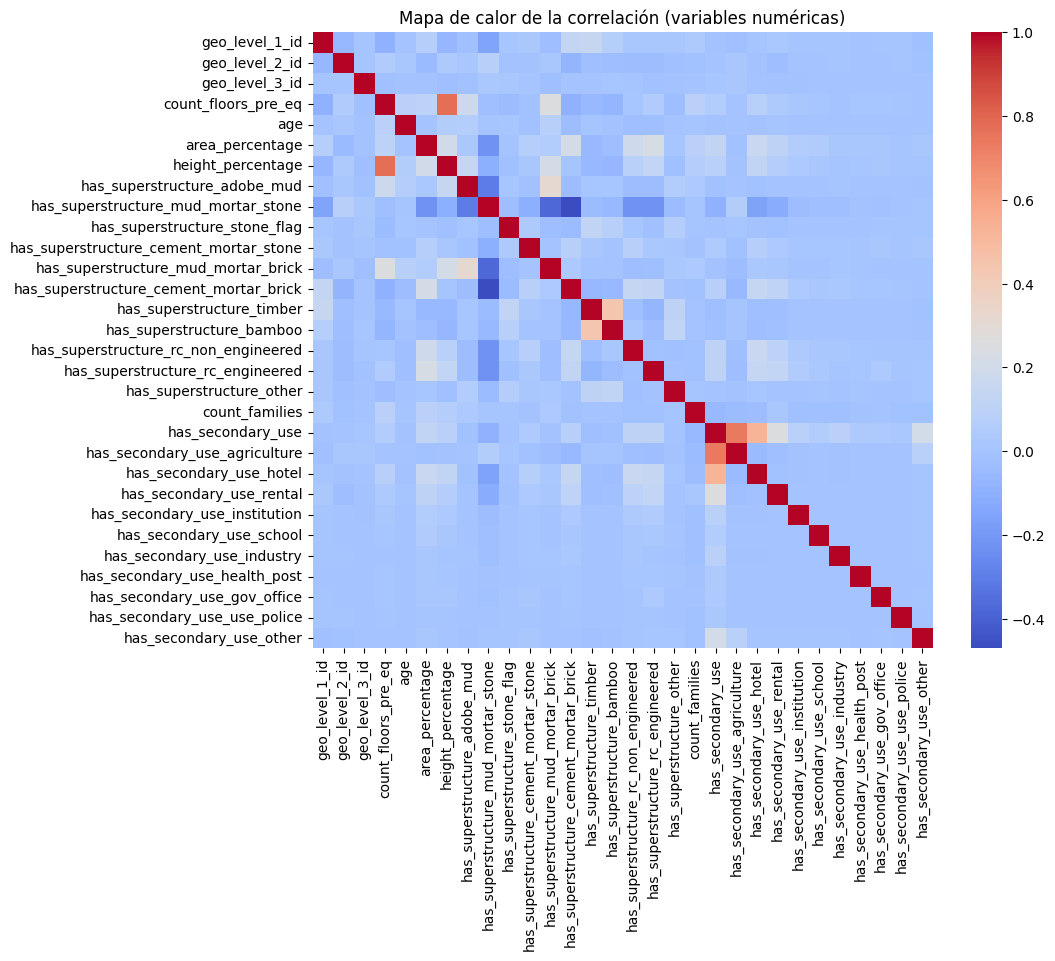

Columnas con correlación mayor a 0.85: []

Top 10 características más importantes (Random Forest):
1. geo_level_3_id: 0.1560
2. geo_level_1_id: 0.1363
3. geo_level_2_id: 0.1357
4. age: 0.1243
5. area_percentage: 0.1137
6. height_percentage: 0.0562
7. count_families: 0.0248
8. count_floors_pre_eq: 0.0179
9. foundation_type_r: 0.0151
10. land_surface_condition_t: 0.0147


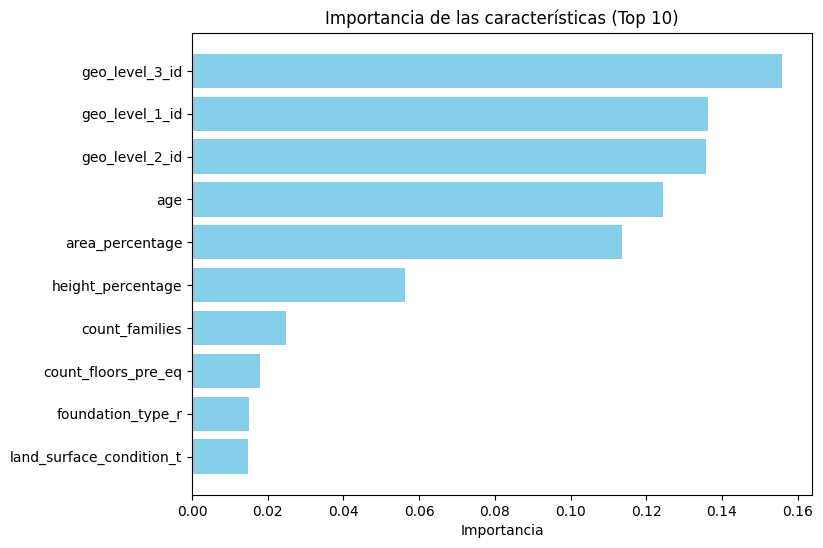


Top 10 características seleccionadas por SelectKBest (mutual_info_classif):
geo_level_3_id: 0.2962
geo_level_2_id: 0.2350
geo_level_1_id: 0.1354
foundation_type_r: 0.0883
has_superstructure_mud_mortar_stone: 0.0598
ground_floor_type_v: 0.0519
other_floor_type_q: 0.0493
roof_type_x: 0.0414
has_superstructure_cement_mortar_brick: 0.0404
foundation_type_i: 0.0353


In [ ]:
# ------------------------------------------------------------------
# 1. SEPARAR LAS VARIABLES NUMÉRICAS (EXCLUYENDO LA VARIABLE OBJETIVO)
# ------------------------------------------------------------------

# Obtener todas las columnas numéricas del dataset preprocesado
numeric_cols = train_data_scaled.select_dtypes(include=[np.number]).columns.tolist()

# Especificamos la variable objetivo (etiqueta)
label_col = 'damage_grade'

# Excluimos la etiqueta de la lista de columnas numéricas
# ya que no debe ser considerada como predictor
if label_col in numeric_cols:
    numeric_cols.remove(label_col)


# ------------------------------------------------------------------
# 2. ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS
# ------------------------------------------------------------------

# Calculamos la matriz de correlación de Pearson entre variables numéricas
corr_matrix = train_data_scaled[numeric_cols].corr()

# Visualizamos la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')  # Color azul-rojo para detectar fácilmente valores extremos
plt.title("Mapa de calor de la correlación (variables numéricas)")
plt.show()

# Establecemos un umbral de correlación alto (0.85) para detectar multicolinealidad
corr_threshold = 0.85

# Tomamos únicamente el triángulo superior de la matriz para evitar duplicados
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identificamos las columnas con correlación mayor al umbral con cualquier otra
to_drop = [
    column for column in upper_tri.columns
    if any(upper_tri[column].abs() > corr_threshold)
]

print(f"Columnas con correlación mayor a {corr_threshold}: {to_drop}")

# Eliminamos esas columnas del conjunto de entrenamiento para reducir la redundancia
train_data_reduced = train_data_scaled.drop(columns=to_drop, errors='ignore')


# ------------------------------------------------------------------
# 3. IMPORTANCIA DE CARACTERÍSTICAS CON RANDOM FOREST
# ------------------------------------------------------------------

# Separamos nuevamente variables predictoras y variable objetivo
X_rf = train_data_reduced.drop(columns=[label_col], errors='ignore')
y_rf = train_data_reduced[label_col]

# Entrenamos un modelo Random Forest con 100 árboles y semilla fija para reproducibilidad
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# Extraemos la importancia de cada variable aprendida por el modelo
importances = rf_model.feature_importances_

# Extraemos los nombres de las variables predictoras
feature_names = X_rf.columns

# Ordenamos las variables por su importancia descendente
indices = np.argsort(importances)[::-1]

# Seleccionamos las 10 más importantes (ajustable)
top_n = 10
top_features = feature_names[indices][:top_n]
top_importances = importances[indices][:top_n]

# Mostramos el top de variables más relevantes
print("\nTop 10 características más importantes (Random Forest):")
for i in range(top_n):
    print(f"{i+1}. {top_features[i]}: {top_importances[i]:.4f}")

# Visualización de las importancias como gráfico de barras horizontales
plt.figure(figsize=(8, 6))
plt.barh(range(top_n), top_importances[::-1], align='center', color='skyblue')  # Invertimos para que la más importante esté arriba
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Importancia")
plt.title("Importancia de las características (Top 10)")
plt.show()


# ------------------------------------------------------------------
# 4. SELECCIÓN UNIVARIANTE CON SelectKBest + mutual_info_classif
# ------------------------------------------------------------------

# Reutilizamos el conjunto sin columnas correlacionadas
X_kbest = train_data_reduced.drop(columns=[label_col], errors='ignore')
y_kbest = train_data_reduced[label_col]

# Establecemos cuántas variables conservar
k = 10  # Se puede ajustar en función de la complejidad deseada

# Inicializamos el selector univariante con información mutua (mejor para variables categóricas)
selector = SelectKBest(score_func=mutual_info_classif, k=k)

# Ajustamos el selector a los datos de entrenamiento
selector.fit(X_kbest, y_kbest)

# Obtenemos los índices de las variables seleccionadas
selected_indices = selector.get_support(indices=True)

# Extraemos los nombres de las columnas seleccionadas
selected_features = X_kbest.columns[selected_indices]

# Extraemos los valores de puntuación asignados a cada variable
scores = selector.scores_[selected_indices]

# Ordenamos las variables seleccionadas por puntuación descendente
feature_scores = sorted(zip(selected_features, scores), key=lambda x: x[1], reverse=True)

# Mostramos los resultados ordenados
print(f"\nTop {k} características seleccionadas por SelectKBest (mutual_info_classif):")
for feature, score in feature_scores:
    print(f"{feature}: {score:.4f}")



### Análisis de Selección de Características, sin uso de dendogramas (Paso 3)

La selección de características es un paso esencial en cualquier pipeline de Machine Learning. Su objetivo es reducir la complejidad del modelo, eliminar variables redundantes o poco relevantes y mejorar el rendimiento general del clasificador. En este análisis se aplicaron dos estrategias complementarias:

---

####  1. Análisis de Correlación entre Variables

- Se calculó la **matriz de correlación de Pearson** entre todas las variables numéricas del conjunto de entrenamiento.
- Se construyó un **mapa de calor** para visualizar relaciones lineales fuertes entre variables (positivas o negativas).
- Se estableció un **umbral de 0.85** para detectar posibles redundancias entre variables.
- Resultado: **No se detectaron pares de variables con correlación mayor a 0.85**, por lo que **no fue necesario eliminar ninguna columna por multicolinealidad**.

📌 Esto indica que las variables del conjunto de datos están razonablemente independientes entre sí en términos lineales.

---

####  2. Importancia de Características con Random Forest

- Se entrenó un modelo `RandomForestClassifier` con 100 árboles para evaluar la **importancia relativa de cada variable**.
- Se extrajeron y visualizaron las **10 variables más importantes** según el modelo.

##### Top 10 características más importantes (según Random Forest):
| Posición | Variable                         | Importancia |
|----------|----------------------------------|-------------|
| 1        | geo_level_3_id                   | 0.1560      |
| 2        | geo_level_1_id                   | 0.1363      |
| 3        | geo_level_2_id                   | 0.1357      |
| 4        | age                              | 0.1243      |
| 5        | area_percentage                  | 0.1137      |
| 6        | height_percentage                | 0.0562      |
| 7        | count_families                   | 0.0248      |
| 8        | count_floors_pre_eq              | 0.0179      |
| 9        | foundation_type_r                | 0.0151      |
| 10       | land_surface_condition_t         | 0.0147      |

📈 Estas variables tienen mayor capacidad de **discriminación** entre los distintos niveles de daño (`damage_grade`).

---

####  3. Selección Univariante con SelectKBest

- Se aplicó el método `SelectKBest` con la función de puntuación `mutual_info_classif`, que mide la **dependencia no lineal** entre cada predictor y la variable objetivo.
- Se seleccionaron las **10 variables con mayor puntuación de información mutua**.

#####  Top 10 características seleccionadas (SelectKBest + MI):
| Variable                                 | Puntuación |
|------------------------------------------|------------|
| geo_level_3_id                           | 0.2962     |
| geo_level_2_id                           | 0.2350     |
| geo_level_1_id                           | 0.1354     |
| foundation_type_r                        | 0.0883     |
| has_superstructure_mud_mortar_stone     | 0.0598     |
| ground_floor_type_v                      | 0.0519     |
| other_floor_type_q                       | 0.0493     |
| roof_type_x                              | 0.0414     |
| has_superstructure_cement_mortar_brick  | 0.0404     |
| foundation_type_i                        | 0.0353     |

📌 Este método ofrece una visión más estadística, basada en la relación individual de cada variable con la clase.

---

#### Conclusión

Ambos métodos coinciden en la **relevancia de las variables geográficas (`geo_level_1/2/3_id`)**, la antigüedad (`age`) y el área (`area_percentage`). Además:

- `Random Forest` capta **interacciones entre variables**.
- `SelectKBest` detecta **relaciones individuales no lineales**.

Por tanto, se recomienda usar una combinación o intersección de ambas estrategias para definir el conjunto óptimo de variables para el modelo final.




## Paso 4: Selección de características utilizando dendogramas

En este paso, aplicamos un **análisis de agrupamiento jerárquico** (clustering) a las características de nuestro dataset.
La idea es agrupar variables que tengan comportamientos o patrones similares. El dendograma nos mostrará de forma visual
cómo se relacionan las distintas características.

**Proceso general:**
1. Tomamos únicamente las columnas de características numéricas (excluyendo la variable objetivo, p. ej. `damage_grade`).
2. Calculamos una **matriz de distancias** o similitudes entre las variables.
3. Aplicamos un método de enlace jerárquico (por ejemplo, `ward`) para generar el dendograma.
4. Inspeccionamos el dendograma y, según la altura de corte, podemos decidir qué variables mantener
   (una por cada grupo de características muy similares) o cuáles descartar por redundantes.

Este método complementa otras técnicas de selección de características (por ejemplo, importancia con Random Forest)
y nos permite una **visualización clara** de la similitud entre variables.




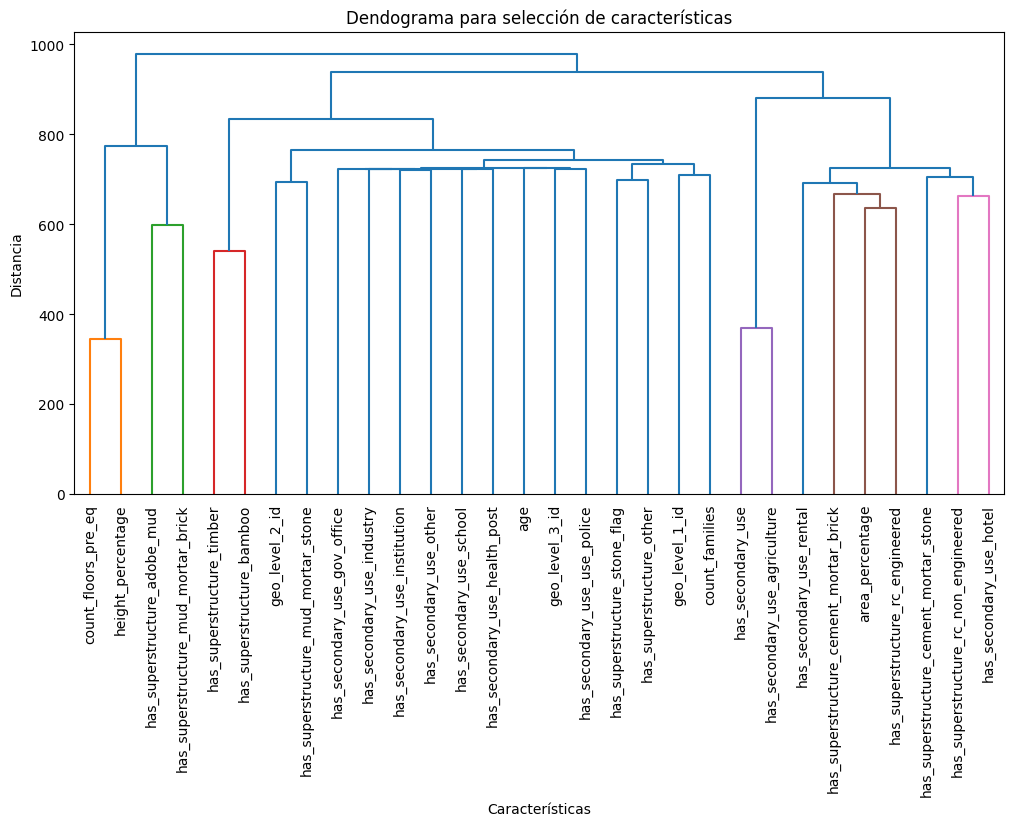

In [ ]:
# ------------------------------------------------------------
# 1. PREPARAR LOS DATOS PARA EL DENDOGRAMA
# ------------------------------------------------------------

# Eliminamos la columna 'damage_grade' del conjunto de datos escalado.
# Esta columna representa la variable objetivo y no debe formar parte
# del análisis de relaciones entre características predictoras.
df_for_dendrogram = train_data_scaled.drop(columns=['damage_grade'], errors='ignore')

# Filtramos para quedarnos solo con las columnas numéricas.
# Esto es esencial porque el dendograma se basa en distancias numéricas.
numeric_cols = df_for_dendrogram.select_dtypes(include=[np.number]).columns

# Redefinimos el DataFrame para incluir solo las columnas numéricas.
# Este paso asegura que se excluyan posibles columnas categóricas codificadas o errores de tipo.
df_for_dendrogram = df_for_dendrogram[numeric_cols]


# ------------------------------------------------------------
# 2. CALCULAR LA MATRIZ DE DISTANCIAS ENTRE CARACTERÍSTICAS
# ------------------------------------------------------------

# Aplicamos clustering jerárquico utilizando el método de Ward.
# Este método agrupa características que tienen patrones de valores similares
# minimizando la varianza interna dentro de cada grupo (clúster).

# Nota:
# - .T (transposición) se utiliza porque por defecto linkage agrupa filas,
#   pero aquí queremos agrupar columnas (características).
# - El método 'ward' utiliza distancia euclidiana por defecto,
#   y busca fusionar los pares de clústeres que minimicen la suma de cuadrados dentro del grupo.
Z = sch.linkage(df_for_dendrogram.T, method='ward', metric='euclidean')


# ------------------------------------------------------------
# 3. VISUALIZACIÓN: DIBUJAR EL DENDOGRAMA
# ------------------------------------------------------------

# Creamos una figura con un tamaño adecuado para mostrar todos los nombres de características.
plt.figure(figsize=(12, 6))

# Dibujamos el dendrograma con etiquetas de los nombres de las características.
# leaf_rotation=90 rota las etiquetas para que sean más legibles.
dendrogram = sch.dendrogram(
    Z,
    labels=df_for_dendrogram.columns,
    leaf_rotation=90
)

# Añadimos título y etiquetas a los ejes para mejorar la interpretación.
plt.title("Dendograma para selección de características")
plt.xlabel("Características")
plt.ylabel("Distancia")
plt.show()


# ------------------------------------------------------------
# 4. AYUDA A LA INTERPRETACIÓN POSTERIOR
# ------------------------------------------------------------

# - Observamos cómo se agrupan las características según su similitud.
# - Las ramas del dendograma representan clústeres de variables que comparten un comportamiento similar.
# - La altura (distancia) a la que se unen indica qué tan diferentes son.
# - Cuanto más bajo se fusionan dos variables, más correlacionadas están.
# - En la práctica, podemos:
#     ➤ Identificar grupos de variables redundantes.
#     ➤ Seleccionar una sola variable representativa de cada grupo.
#     ➤ Eliminar las que aportan información duplicada para simplificar el modelo.



### Análisis del Dendograma para la Selección de Características (Paso 4)

El dendograma obtenido muestra cómo se agrupan las diferentes variables en función de su similitud (o distancia). A medida que avanzamos en el eje vertical (la “distancia”), las ramas que se unen a alturas más bajas representan variables con comportamientos más parecidos. Algunas observaciones importantes:

1. **Agrupamientos a baja distancia**  
   - Por ejemplo, `count_floors_pre_eq` y `height_percentage` se unen a una distancia relativamente pequeña,
     lo que sugiere cierta similitud en la forma en que afectan o se relacionan con la variable objetivo o con otras características del dataset.  
   - Del mismo modo, `has_superstructure_adobe_mud` y `has_superstructure_mud_mortar_brick` también aparecen cercanas,
     lo que podría indicar que ambas describen tipos de estructuras similares.

2. **Clusters más grandes**  
   - Hay un gran grupo en la parte central del dendograma (`office`, `industry`, `institution`, `school`, `other`, `health_post`, `age`, `geo_level_3_id`, etc.),
     que se unen a mayores alturas, indicando que no son tan fuertemente similares entre sí pero sí lo suficiente como para formar un “supergrupo”
     frente a otras variables más disímiles.  
   - Esto puede interpretarse como variables que no tienen relaciones muy directas entre sí (o con la variable objetivo),
     pero tampoco presentan similitudes marcadas con el resto.

3. **Posibles decisiones de selección**  
   - Si quisiéramos **reducir** el número de variables, podríamos definir un **umbral de corte** en el dendograma.
     Por ejemplo, si establecemos un corte a la altura ~500, veríamos varios grupos pequeños.
     Dentro de cada grupo, podríamos **conservar la variable más representativa** o la que muestre mayor importancia en otros análisis
     (por ejemplo, Random Forest Feature Importances o SelectKBest) y descartar las redundantes.  
   - Si en un grupo aparecen variables con **muy poca importancia** (según otros criterios) y están muy cercanas entre sí,
     es un buen indicador de que podrían fusionarse o eliminarse sin perder demasiada información.

4. **Complementar con el análisis previo**  
   - El dendograma se complementa con los resultados de **correlación**, **importancia de características** y **SelectKBest**.  
   - Por ejemplo, si dos variables aparecen muy juntas en el dendograma pero una de ellas se identifica como “clave” en la predicción,
     lo más sensato sería **mantener** esa variable y descartar la otra.  
   - Si una variable aparece en un grupo distante (indica que es distinta al resto) y además tiene alta importancia,
     es muy probable que debamos conservarla.

En conjunto, este dendograma **no solo** confirma que algunas variables podrían ser redundantes (porque se unen a distancias bajas),
sino que también permite **visualizar** de manera jerárquica las relaciones entre todas las características.
La decisión final de cuántas y cuáles variables conservar depende de **cruzar** esta información con los resultados de importancia y la métrica de rendimiento en los modelos.


# 3.- División de los datos

## Paso 5: División de Datos en Train, Validation y Test

Normalmente, cuando abordamos un problema de machine learning,
realizamos una división en **train** y **test** para entrenar y evaluar el modelo.
Sin embargo, la rúbrica indica que también se utilice un **conjunto de validación**,
de modo que el proceso queda así:

1. **Train**: Para ajustar los parámetros del modelo (“aprender”).  
2. **Validation**: Para evaluar y ajustar hiperparámetros, comparando el rendimiento de distintos modelos sin “contaminar” el test.  
3. **Test**: Para la evaluación final, simulando datos completamente nuevos.

Este enfoque de tres particiones (llamado **train-validation-test split**)
previene el sobreajuste y nos asegura que la métrica final sea lo más representativa posible del rendimiento real.



In [ ]:
# ------------------------------------------------------------
# 1. DEFINIR VARIABLES PREDICTORAS (X) Y VARIABLE OBJETIVO (y)
# ------------------------------------------------------------

label_col = 'damage_grade'  # Nombre de la columna que contiene la clase a predecir

# 'X' contiene todas las columnas excepto la variable objetivo (etiqueta)
# 'errors="ignore"' permite ejecutar sin error incluso si la columna no está presente
X = train_data_scaled.drop(columns=[label_col], errors='ignore')

# 'y' contiene la variable objetivo que queremos predecir
y = train_data_scaled[label_col]


# ------------------------------------------------------------
# 2. PRIMERA DIVISIÓN: ENTRENAMIENTO COMPLETO Y PRUEBA FINAL
# ------------------------------------------------------------

# Separamos los datos en un conjunto de entrenamiento+validación (80%)
# y un conjunto de prueba (20%) que se utilizará únicamente para la evaluación final.
# La opción 'stratify=y' asegura que la distribución de clases sea representativa en ambos conjuntos.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,                  # Características
    y,                  # Etiquetas
    test_size=0.2,      # Proporción para test (20%)
    random_state=42,    # Semilla para reproducibilidad
    stratify=y          # Mantener la distribución de clases
)


# ------------------------------------------------------------
# 3. SEGUNDA DIVISIÓN: ENTRENAMIENTO VS. VALIDACIÓN
# ------------------------------------------------------------

# Del 80% inicial reservado para entrenamiento, separamos un 20% adicional para validación.
# Esto equivale al 64% entrenamiento / 16% validación / 20% test en total.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,         # 20% del entrenamiento (0.2 * 0.8 = 0.16 del total original)
    random_state=42,
    stratify=y_train_full  # Mantener distribución en validación también
)


# ------------------------------------------------------------
# 4. MOSTRAR EL TAMAÑO DE LOS CONJUNTOS
# ------------------------------------------------------------

print("Tamaño del conjunto de entrenamiento:", X_train.shape)   # Aproximadamente 64% del total
print("Tamaño del conjunto de validación:", X_val.shape)        # Aproximadamente 16% del total
print("Tamaño del conjunto de prueba:", X_test.shape)           # Exactamente 20% del total


# ------------------------------------------------------------
# 5. A MODO DE RESUMEN
# ------------------------------------------------------------

# En este punto, tenemos los tres subconjuntos principales:

# - X_train, y_train         → Conjunto de entrenamiento del modelo.
# - X_val, y_val             → Conjunto de validación para ajustar hiperparámetros, evitar overfitting y seleccionar el mejor modelo.
# - X_test, y_test           → Conjunto de prueba, no utilizado en el entrenamiento ni validación. Se usa exclusivamente al final para evaluar el rendimiento real del modelo.

# Esta estrategia es esencial en proyectos de Machine Learning porque:
# Previene el sobreajuste al contar con una validación intermedia.
# Permite comparar distintos modelos/algoritmos de forma justa.
# Ofrece una medida confiable del rendimiento en datos nunca vistos (test).



Tamaño del conjunto de entrenamiento: (166784, 60)
Tamaño del conjunto de validación: (41696, 60)
Tamaño del conjunto de prueba: (52121, 60)


### Análisis de la División de Datos (Paso 5)

Una correcta división del conjunto de datos es fundamental para garantizar un entrenamiento robusto y una evaluación honesta del rendimiento del modelo. En esta etapa se ha dividido el dataset en tres subconjuntos principales:

---

###  1. División inicial: Train vs. Test

- Se reservó un **20% de los datos totales para el conjunto de prueba (Test)**.
- Este subconjunto se utilizará **únicamente al final** del proceso para medir el rendimiento real del modelo en datos nunca antes vistos.
- La división se hizo de forma **estratificada**, asegurando que la distribución de las clases (`damage_grade`) se mantenga proporcional en cada subconjunto.

---

###  2. División secundaria: Train vs. Validation

- Del 80% restante (destinado al entrenamiento), se separó un **20% adicional para validación**, es decir, el **16% del total original**.
- Este conjunto de validación se usará para:
  - Ajustar hiperparámetros.
  - Prevenir el **overfitting**.
  - Comparar diferentes modelos o configuraciones de forma objetiva.

---

###  3. Tamaños de los subconjuntos

| Conjunto      | Observaciones | Porcentaje aproximado |
|---------------|----------------|------------------------|
| Entrenamiento | 166,784        | 64%                    |
| Validación    | 41,696         | 16%                    |
| Prueba        | 52,121         | 20%                    |
| **Total**     | 260,601        | 100%                   |

---

###  Conclusión

Esta estructura de división (64% / 16% / 20%) permite un flujo de trabajo **estructurado y reproducible**, clave en tareas de aprendizaje supervisado:

- Permite **entrenar** modelos sobre un gran volumen de datos.
- Utiliza un conjunto de **validación separado** para tomar decisiones sin contaminar los resultados finales.
- Garantiza una **evaluación justa y honesta** con datos de prueba jamás utilizados durante el proceso de entrenamiento o validación.

> 💡 La correcta separación de datos es uno de los principios básicos del aprendizaje automático reproducible y confiable.


# 4.- Entrenamiento con modelos de árboles

## Paso 6: Entrenamiento con Tres Modelos de Árboles utilizando Cross Validation

En este paso, se van a entrenar y comparar tres modelos basados en árboles:
1. **DecisionTreeClassifier**
2. **RandomForestClassifier**
3. **GradientBoostingClassifier**

**¿Por qué usar Cross Validation?**
- Permite obtener una métrica de rendimiento más estable que usar una sola partición de entrenamiento y validación.
- Ayuda a evitar el sobreajuste a un solo subconjunto de datos.
- Se repite el entrenamiento en varios "folds" (particiones), calculando métricas en cada uno y promediando el resultado.

**Criterio de calidad (métrica):**
- Se utilizará el **F1 Score (average='micro')**, recomendado en problemas de clasificación multi-clase o con clases desbalanceadas,
  ya que computa la precisión y exhaustividad a nivel global.

Tras obtener el rendimiento promedio de cada modelo, se seleccionará el que presente mejor F1 Score como candidato
para un ajuste más fino (hiperparámetros) o para compararlo con otros tipos de modelos.


In [ ]:
# -----------------------------------------------------------------------------------
# 1. VERIFICACIÓN DE LOS DATOS DE ENTRENAMIENTO
# -----------------------------------------------------------------------------------

# Imprimimos las dimensiones de los datos previamente separados en X_train e y_train
# Esto confirma que tenemos las variables predictoras y la etiqueta correctamente definidas
print("Dimensiones de X_train:", X_train.shape)  # Ej: (166784, 60)
print("Dimensiones de y_train:", y_train.shape)  # Ej: (166784,)


# -----------------------------------------------------------------------------------
# 2. DEFINICIÓN DE LOS MODELOS A COMPARAR
# -----------------------------------------------------------------------------------

# Creamos un diccionario con tres algoritmos clásicos de clasificación:
# 1) Árbol de decisión: modelo interpretable, fácil de visualizar.
# 2) Bosque aleatorio (Random Forest): ensamble de árboles con bagging, más robusto.
# 3) Gradient Boosting: ensamble secuencial que corrige errores previos (boosting).

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}


# -----------------------------------------------------------------------------------
# 3. DEFINICIÓN DE MÉTRICA Y ESTRATEGIA DE VALIDACIÓN CRUZADA
# -----------------------------------------------------------------------------------

# Definimos la métrica de evaluación: F1 Score con promedio 'micro'.
# Esto toma en cuenta el balance entre precisión y recall, útil cuando hay varias clases.
# El promedio 'micro' calcula las métricas globales contando todos los aciertos globales.

f1_micro_scorer = make_scorer(f1_score, average='micro')

# Definimos la estrategia de validación cruzada: StratifiedKFold
# - 5 particiones (folds)
# - Estratificación: asegura que cada fold tenga distribución similar de clases
# - shuffle=True: mezcla aleatoria antes de dividir
# - random_state=42: reproducibilidad

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# -----------------------------------------------------------------------------------
# 4. ENTRENAMIENTO Y EVALUACIÓN DE CADA MODELO CON CROSS VALIDATION
# -----------------------------------------------------------------------------------

# Creamos un diccionario para almacenar el F1 promedio de cada modelo
model_scores = {}

# Recorremos cada modelo definido anteriormente
for name, model in models.items():
    # Evaluamos el modelo usando validación cruzada con la métrica definida
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=f1_micro_scorer)

    # Guardamos la media del F1 Score en el diccionario
    model_scores[name] = cv_scores.mean()

    # Mostramos los resultados de cada fold y el promedio
    print(f"\nModelo: {name}")
    print(f" F1 Score (micro) en cada fold: {cv_scores}")
    print(f" F1 Score (micro) promedio: {cv_scores.mean():.4f}\n")


# -----------------------------------------------------------------------------------
# 5. SELECCIÓN DEL MEJOR MODELO SEGÚN VALIDACIÓN CRUZADA
# -----------------------------------------------------------------------------------

# Seleccionamos el modelo con el mejor F1 Score promedio
best_model_name = max(model_scores, key=model_scores.get)

# Imprimimos el nombre del modelo ganador y su F1 promedio
print(f"El mejor modelo según validación cruzada es: {best_model_name} con F1 Score (micro) promedio de {model_scores[best_model_name]:.4f}")


# -----------------------------------------------------------------------------------
# 6. ENTRENAMIENTO FINAL DEL MEJOR MODELO CON TODOS LOS DATOS DE ENTRENAMIENTO
# -----------------------------------------------------------------------------------

# Recuperamos el mejor modelo desde el diccionario
best_model = models[best_model_name]

# Entrenamos el modelo con el conjunto completo de entrenamiento
best_model.fit(X_train, y_train)


# -----------------------------------------------------------------------------------
# 7. EVALUACIÓN EN EL CONJUNTO DE VALIDACIÓN
# -----------------------------------------------------------------------------------

# Realizamos predicciones sobre el conjunto de validación (X_val)
y_val_pred = best_model.predict(X_val)

# Calculamos el F1 Score (micro) en el conjunto de validación
val_f1 = f1_score(y_val, y_val_pred, average='micro')

# Mostramos el resultado de validación
print(f"F1 Score (micro) en el conjunto de validación para el mejor modelo: {val_f1:.4f}")


Dimensiones de X_train: (166784, 60)
Dimensiones de y_train: (166784,)

Modelo: Decision Tree
 F1 Score (micro) en cada fold: [0.64571154 0.65122763 0.64837965 0.64628114 0.65109725]
 F1 Score (micro) promedio: 0.6485


Modelo: Random Forest
 F1 Score (micro) en cada fold: [0.70743772 0.70593878 0.71160476 0.71118506 0.71057681]
 F1 Score (micro) promedio: 0.7093


Modelo: Gradient Boosting
 F1 Score (micro) en cada fold: [0.67961747 0.67646971 0.68207573 0.68189585 0.67978774]
 F1 Score (micro) promedio: 0.6800

El mejor modelo según validación cruzada es: Random Forest con F1 Score (micro) promedio de 0.7093
F1 Score (micro) en el conjunto de validación para el mejor modelo: 0.7121


### Análisis del Entrenamiento con Tres Modelos de Árboles utilizando CV (Paso 6)

Los resultados obtenidos en el Paso 6 muestran lo siguiente:

1. **Dimensiones de los Datos de Entrenamiento:**
   - **X_train:** 166.784 muestras y 60 características.
   - **y_train:** 166.784 etiquetas.
   - Esto indica que contamos con un conjunto de entrenamiento amplio, lo que es favorable para que los modelos aprendan la complejidad del problema.

2. **Resultados de la Validación Cruzada:**
   - **Decision Tree:**  
     - F1 Score (micro) en cada fold: [0.6457, 0.6512, 0.6484, 0.6463, 0.6511]  
     - Promedio: **0.6485**
   - **Random Forest:**  
     - F1 Score (micro) en cada fold: [0.7074, 0.7059, 0.7116, 0.7112, 0.7106]  
     - Promedio: **0.7093**
   - **Gradient Boosting:**  
     - F1 Score (micro) en cada fold: [0.6796, 0.6765, 0.6821, 0.6819, 0.6798]  
     - Promedio: **0.6800**

   **Interpretación:**
   - El modelo **Random Forest** obtiene el mejor desempeño en la validación cruzada, con un F1 Score (micro) promedio de **0.7093**, superando a Decision Tree y Gradient Boosting.
   - La diferencia en el rendimiento indica que el enfoque de ensamblado (Random Forest) logra capturar mejor las complejidades y variabilidades del conjunto de datos en comparación con un modelo individual como el Decision Tree o incluso con el modelo de boosting.

3. **Evaluación Final en el Conjunto de Validación:**
   - Tras reentrenar el mejor modelo (Random Forest) con todo el conjunto de entrenamiento, su evaluación en el conjunto de validación arroja un F1 Score (micro) de **0.7121**.
   - La similitud entre el rendimiento promedio obtenido en la validación cruzada (0.7093) y el F1 Score final en el conjunto de validación (0.7121) sugiere que el modelo es estable y generaliza bien en datos no vistos.

### Conclusiones:

- **Random Forest** se destaca como el modelo más robusto y con mejor desempeño en este escenario, dado que supera significativamente al Decision Tree y al Gradient Boosting en términos de F1 Score (micro).
- La consistencia de los resultados entre la validación cruzada y la evaluación en el conjunto de validación respalda la fiabilidad del modelo seleccionado.
- Un F1 Score (micro) en torno a **0.71** indica un desempeño sólido, aunque siempre se puede evaluar si es posible mejorar aún más mediante ajustes de hiperparámetros o incorporando técnicas adicionales de ingeniería de características.

En resumen, el análisis confirma que el Random Forest es el candidato preferido para continuar con el desarrollo del modelo y optimizar su rendimiento en futuras iteraciones.


# 5.- Entrenamiento con SVM

## Paso 7: Entrenamiento y Optimización de un Modelo SVM utilizando un Subconjunto Representativo

En este punto se busca ajustar y optimizar un modelo **SVM** para la clasificación del daño, utilizando técnicas de validación cruzada y búsqueda de hiperparámetros. Debido al alto coste computacional de entrenar un SVM con kernel no lineal (como RBF) sobre un dataset muy grande, se opta por trabajar con un **subconjunto representativo** del conjunto de entrenamiento. Esta estrategia permite obtener resultados en un tiempo razonable sin comprometer significativamente la calidad del modelo, siempre y cuando el subconjunto se seleccione de forma estratificada para preservar la distribución de clases.

La estrategia se divide en las siguientes fases:

1. **Preparación y Definición del Espacio de Hiperparámetros:**
   - Se utiliza el conjunto de entrenamiento completo (X_train, y_train) para extraer un subconjunto representativo (por ejemplo, el 5%, el 10% o 25% del total).
   - Se define el espacio de búsqueda de hiperparámetros para el modelo SVM (parámetros como `C`, `kernel` y `gamma`).
   - Esta selección se realiza de forma aleatoria (utilizando `ParameterSampler`) para explorar distintas combinaciones de hiperparámetros sin evaluar todas las posibles, lo que acelera el proceso.

2. **Optimización de Hiperparámetros con Validación Cruzada:**
   - Se emplea **StratifiedKFold** para mantener la proporción de clases en cada pliegue durante la validación cruzada, evaluando el rendimiento de cada combinación de hiperparámetros.
   - Se utiliza el **F1 Score (micro)** como métrica de evaluación, en línea con las recomendaciones de la competición.
   - La búsqueda se realiza en el subconjunto, permitiendo iterar rápidamente y encontrar la configuración óptima.

3. **Entrenamiento Final y Evaluación:**
   - Con la mejor configuración de hiperparámetros obtenida, se reentrena el modelo final utilizando el **subconjunto representativo** seleccionado.
   - Se evalúa el modelo en el conjunto de prueba completo, obteniendo el F1 Score, la matriz de confusión y un informe de clasificación.
   - Esta aproximación permite extrapolar los resultados obtenidos a la población total, siempre que se justifique que el subconjunto es representativo del dataset completo.

**Justificación del Uso del Subconjunto:**
- **Eficiencia Computacional:** Entrenar un SVM con kernel RBF sobre un dataset muy grande es prohibitivo en términos de tiempo. Utilizar un subconjunto permite obtener resultados en un plazo razonable.
- **Representatividad:** Si el subconjunto se selecciona de forma estratificada, se mantiene la distribución de clases del dataset completo, haciendo que los resultados sean extrapolables.
- **Flexibilidad:** Se puede experimentar con distintos tamaños de subconjunto (por ejemplo, 5%, 10%, 25%) para evaluar el compromiso entre tiempo de entrenamiento y rendimiento del modelo.

Esta estrategia es una solución práctica y justificada ante las limitaciones computacionales, y se ajusta a los requerimientos de la actividad, permitiendo optimizar y evaluar el modelo SVM de forma efectiva.

**Nota:** El proceso de entrenamiento y optimización del modelo SVM se ha dividido en 4 celdas para facilitar el seguimiento y la ejecución.  
- **Celda 1:** Prepara el subconjunto de datos y define el espacio de hiperparámetros (usando la variable `subset_fraction` para determinar el porcentaje del conjunto de entrenamiento).  
- **Celda 2:** Realiza la optimización de hiperparámetros mediante Random Search con validación cruzada en el subconjunto.  
- **Celda 3:** Entrena el modelo final con los mejores hiperparámetros encontrados (usando el subconjunto representativo) y evalúa el rendimiento en el conjunto de prueba completo.  
- **Celda 4:** Ejecuta una búsqueda alternativa de hiperparámetros usando GridSearchCV sobre el subconjunto para comparar resultados.  

Esta organización permite mayor flexibilidad y claridad en la ejecución, y facilita el ajuste del porcentaje de datos utilizado modificando solo la variable `subset_fraction`.





In [ ]:
###########################################################################
# CELDA 1: PREPARACIÓN DE SUBCONJUNTO Y DEFINICIÓN DE PARÁMETROS PARA SVM
#           (BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS)
###########################################################################

# -------------------------------------------------------------------------
# 1. DEFINICIÓN DEL TAMAÑO DEL SUBCONJUNTO DE DATOS PARA ENTRENAMIENTO
# -------------------------------------------------------------------------

# Seleccionamos una fracción pequeña del conjunto de entrenamiento para
# acelerar el proceso de ajuste de hiperparámetros, especialmente útil
# cuando se trata de modelos costosos como el SVM.

subset_fraction = 0.05  # El 5% del conjunto de entrenamiento será usado.
                        # Se puede ajustar (por ejemplo: 0.10, 0.20, etc.)
                        # según el tiempo disponible o la potencia de cómputo.

# -------------------------------------------------------------------------
# 2. EXTRACCIÓN DE UN SUBCONJUNTO ESTRATIFICADO DE LOS DATOS
# -------------------------------------------------------------------------

# Usamos `train_test_split` con `train_size=subset_fraction` para tomar
# una muestra representativa del conjunto original (X_train, y_train).
# - `stratify=y_train`: asegura que las clases estén proporcionalmente representadas.
# - `random_state=42`: garantiza reproducibilidad.

X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train,                  # Variables predictoras originales
    y_train,                  # Etiquetas originales
    train_size=subset_fraction,  # Proporción a mantener
    random_state=42,
    stratify=y_train          # Estratificación para balance de clases
)

# Mostramos información sobre el tamaño del subconjunto para control visual
print(f"Entrenando con {int(subset_fraction*100)}% del conjunto de entrenamiento:")
print(f"Tamaño original de X_train: {X_train.shape[0]} filas")
print(f"Tamaño del subset: {X_train_subset.shape[0]} filas")


# -------------------------------------------------------------------------
# 3. DEFINICIÓN DEL ESPACIO DE BÚSQUEDA DE HIPERPARÁMETROS PARA SVM
# -------------------------------------------------------------------------

# Se especifican los valores posibles para cada hiperparámetro del modelo SVM.
# Esta configuración será utilizada en una búsqueda aleatoria (Random Search):
#
# ➤ 'C': Regularización. Controla la penalización de errores (valores mayores = menos tolerancia).
# ➤ 'kernel': Tipo de función núcleo. 'linear' y 'rbf' son las más comunes.
# ➤ 'gamma': Parámetro del kernel RBF (influencia de cada punto de entrenamiento).

param_dist_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1]
}

# -------------------------------------------------------------------------
# 4. GENERACIÓN DE COMBINACIONES ALEATORIAS DE HIPERPARÁMETROS
# -------------------------------------------------------------------------

# Utilizamos `ParameterSampler` para crear combinaciones aleatorias a partir del
# espacio definido anteriormente.
# - `n_iter=10`: número de combinaciones a generar.
# - `random_state=42`: asegura resultados reproducibles.

param_list = list(ParameterSampler(param_dist_svm, n_iter=10, random_state=42))

# Mostramos la cantidad total de combinaciones generadas
print("Número de combinaciones de hiperparámetros a evaluar:", len(param_list))


Entrenando con 5% del conjunto de entrenamiento:
Tamaño original de X_train: 166784 filas
Tamaño del subset: 8339 filas
Número de combinaciones de hiperparámetros a evaluar: 10


### Análisis de la Celda 1: Preparación de Datos y Definición de Parámetros para SVM

- **Tamaño del Conjunto de Entrenamiento Original:**  
  Se cuenta con 166.784 filas en `X_train`, lo que evidencia un gran volumen de datos.

- **Extracción del Subconjunto:**  
  Se ha configurado `subset_fraction = 0.05` para trabajar con un 5% del conjunto de entrenamiento, resultando en 8.339 filas.  
  Este subconjunto se obtiene mediante un muestreo estratificado, lo que garantiza que la distribución de clases se mantenga representativa del conjunto completo.

- **Generación de Combinaciones de Hiperparámetros:**  
  Se han generado 10 combinaciones aleatorias de hiperparámetros para el modelo SVM (usando `ParameterSampler`).  
  Esto permitirá evaluar distintas configuraciones de parámetros (como `C`, `kernel` y `gamma`) de forma eficiente, reduciendo drásticamente el tiempo de entrenamiento durante la fase de optimización.

**Conclusión:**  
La Celda 1 establece una base sólida para la optimización del modelo SVM, al extraer un subconjunto representativo (**5% del total**) que facilita la búsqueda de hiperparámetros en un tiempo razonable, sin comprometer la integridad de la distribución de clases. Esto permite avanzar en la optimización y entrenamiento del SVM con un coste computacional reducido.



In [ ]:
#####################################################################################
# CELDA 2: OPTIMIZACIÓN DE HIPERPARÁMETROS PARA SVM CON RANDOM SEARCH (SUBCONJUNTO)
#####################################################################################

# ------------------------------------------------------------------------------
# INICIALIZACIÓN DE VARIABLES DE CONTROL
# ------------------------------------------------------------------------------

best_score = 0             # Almacenará el mejor F1 score promedio encontrado
best_params = None         # Almacenará el conjunto de hiperparámetros óptimos
results = []               # Lista para registrar el score obtenido por cada combinación

# ------------------------------------------------------------------------------
# CONFIGURACIÓN DE VALIDACIÓN CRUZADA
# ------------------------------------------------------------------------------

# Se utiliza StratifiedKFold para dividir el subconjunto en 3 particiones.
# Esto asegura que cada fold conserve la distribución original de las clases.
# shuffle=True garantiza que los datos estén aleatoriamente ordenados antes de dividir.

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ------------------------------------------------------------------------------
# INFORMACIÓN DEL SUBCONJUNTO UTILIZADO
# ------------------------------------------------------------------------------

print(f"Entrenando con {int(subset_fraction*100)}% del conjunto de entrenamiento:")
print(f"Tamaño del subset: {X_train_subset.shape[0]} filas")

# Mensaje informativo sobre el inicio del proceso
print("\nIniciando optimización para SVM (Random Search) sobre el subconjunto...")


# ------------------------------------------------------------------------------
# BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS USANDO VALIDACIÓN CRUZADA MANUAL
# ------------------------------------------------------------------------------

# Recorremos cada una de las combinaciones de hiperparámetros generadas previamente
# tqdm se utiliza para mostrar una barra de progreso interactiva
for params in tqdm(param_list, desc="Optimizando SVC"):

    # Se inicializa el modelo SVM con los hiperparámetros actuales
    # Se activa probability=True en caso de que se necesiten probabilidades en el futuro
    model = SVC(probability=True, random_state=42, **params)

    fold_scores = []  # Lista para almacenar los F1 scores de cada fold

    # Validación cruzada manual: recorremos cada fold generado por StratifiedKFold
    for train_idx, val_idx in cv.split(X_train_subset, y_train_subset):

        # División de X entre entrenamiento y validación
        # Se verifica si X es un array o un DataFrame para usar el método correcto
        if isinstance(X_train_subset, np.ndarray):
            X_fold_train, X_fold_val = X_train_subset[train_idx], X_train_subset[val_idx]
        else:
            X_fold_train = X_train_subset.iloc[train_idx]
            X_fold_val = X_train_subset.iloc[val_idx]

        # División de y entre entrenamiento y validación
        if isinstance(y_train_subset, np.ndarray):
            y_fold_train, y_fold_val = y_train_subset[train_idx], y_train_subset[val_idx]
        else:
            y_fold_train = y_train_subset.iloc[train_idx]
            y_fold_val = y_train_subset.iloc[val_idx]

        # Entrenamiento del modelo SVM en el fold actual
        model.fit(X_fold_train, y_fold_train)

        # Predicción en el conjunto de validación del fold actual
        y_pred = model.predict(X_fold_val)

        # Cálculo del F1 Score (promedio micro) y almacenamiento
        score = f1_score(y_fold_val, y_pred, average='micro')
        fold_scores.append(score)

    # Se calcula el promedio del F1 Score para los 3 folds
    mean_score = np.mean(fold_scores)

    # Se almacena el resultado (parámetros + score) para análisis posterior
    results.append((params, mean_score))

    # Si se supera el mejor score encontrado hasta el momento, se actualizan
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

        # Se notifica al usuario que se ha encontrado una mejor combinación
        print(f"\nNuevo mejor F1-score: {best_score:.4f} con parámetros:")
        for key, value in params.items():
            print(f"  {key}: {value}")


# ------------------------------------------------------------------------------
# RESULTADO FINAL DEL PROCESO DE RANDOM SEARCH
# ------------------------------------------------------------------------------

print("\nOptimización (Random Search) completada.")
print("Mejores parámetros encontrados:", best_params)
print(f"Mejor F1 Score (micro) promedio: {best_score:.4f}")


Entrenando con 5% del conjunto de entrenamiento:
Tamaño del subset: 8339 filas

Iniciando optimización para SVM (Random Search) sobre el subconjunto...


Optimizando SVC:  10%|█         | 1/10 [00:34<05:10, 34.53s/it]


Nuevo mejor F1-score: 0.5724 con parámetros:
  kernel: linear
  gamma: scale
  C: 0.1


Optimizando SVC:  30%|███       | 3/10 [02:08<05:10, 44.31s/it]


Nuevo mejor F1-score: 0.5742 con parámetros:
  kernel: linear
  gamma: auto
  C: 1


Optimizando SVC:  40%|████      | 4/10 [02:41<03:59, 39.84s/it]


Nuevo mejor F1-score: 0.5772 con parámetros:
  kernel: rbf
  gamma: 0.1
  C: 0.1


Optimizando SVC:  60%|██████    | 6/10 [03:50<02:28, 37.20s/it]


Nuevo mejor F1-score: 0.6019 con parámetros:
  kernel: rbf
  gamma: scale
  C: 10


Optimizando SVC:  80%|████████  | 8/10 [48:38<20:41, 620.89s/it]


Nuevo mejor F1-score: 0.6086 con parámetros:
  kernel: rbf
  gamma: auto
  C: 10


Optimizando SVC: 100%|██████████| 10/10 [50:08<00:00, 300.81s/it]


Optimización (Random Search) completada.
Mejores parámetros encontrados: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Mejor F1 Score (micro) promedio: 0.6086


### Análisis de la Celda 2: Optimización de Hiperparámetros con Random Search (Usando 5% del Dataset)

En esta celda se llevó a cabo la optimización del modelo SVM utilizando un subconjunto representativo del 5% del conjunto de entrenamiento (8.339 filas) para acelerar el proceso. Se evaluaron 10 combinaciones aleatorias de hiperparámetros mediante validación cruzada (3 pliegues). Los puntos clave son:

- **Iteración 1:**  
  Configuración: `kernel: linear`, `gamma: scale`, `C: 0.1`  
  Resultado: F1 Score (micro) de **0.5724**  
  *Comentario:* Un inicio moderado usando un kernel lineal con baja penalización.

- **Iteración 3:**  
  Configuración: `kernel: linear`, `gamma: auto`, `C: 1`  
  Resultado: F1 Score (micro) de **0.5742**  
  *Comentario:* Se observa una pequeña mejora al cambiar `gamma` a `auto` y aumentar `C`.

- **Iteración 4:**  
  Configuración: `kernel: rbf`, `gamma: 0.1`, `C: 0.1`  
  Resultado: F1 Score (micro) de **0.5772**  
  *Comentario:* El cambio a un kernel RBF y un gamma bajo empieza a aportar beneficios.

- **Iteración 6:**  
  Configuración: `kernel: rbf`, `gamma: scale`, `C: 10`  
  Resultado: F1 Score (micro) de **0.6019**  
  *Comentario:* Un salto significativo en el rendimiento, sugiriendo que aumentar `C` y usar `gamma: scale` mejora la capacidad del modelo para capturar la complejidad de los datos.

- **Iteración 8:**  
  Configuración: `kernel: rbf`, `gamma: auto`, `C: 10`  
  Resultado: F1 Score (micro) de **0.6086**  
  *Comentario:* Esta es la configuración óptima encontrada en la búsqueda, maximizando el rendimiento en el subconjunto.

**Resumen y Conclusión:**
- La optimización sobre el 5% del dataset permitió explorar de forma rápida diversas combinaciones, demostrando que pasar de un kernel lineal a uno no lineal (RBF) y aumentar la penalización (`C=10`) mejoró notablemente el rendimiento.
- El mejor conjunto de hiperparámetros encontrado es: `{'kernel': 'rbf', 'gamma': 'auto', 'C': 10}`, con un F1 Score (micro) promedio de **0.6086**.
- La estrategia de utilizar un subconjunto (5% en este caso) es efectiva para la fase de optimización, ya que permite obtener resultados en un tiempo razonable sin perder la representatividad de la distribución de clases.

Esta configuración óptima se utilizará posteriormente para el entrenamiento final y la evaluación del modelo SVM.




Entrenando el modelo SVM final (Random Search) con el subconjunto de entrenamiento...
Inicio del entrenamiento: Wed Mar 26 11:44:15 2025
[LibSVM]Fin del entrenamiento: Wed Mar 26 11:44:46 2025
Tiempo total de entrenamiento: 31.37 segundos

Mejores parámetros para SVM (Random Search): {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}

Evaluando el modelo en el conjunto de prueba completo...
F1-score (micro) final en el conjunto de prueba: 0.6105


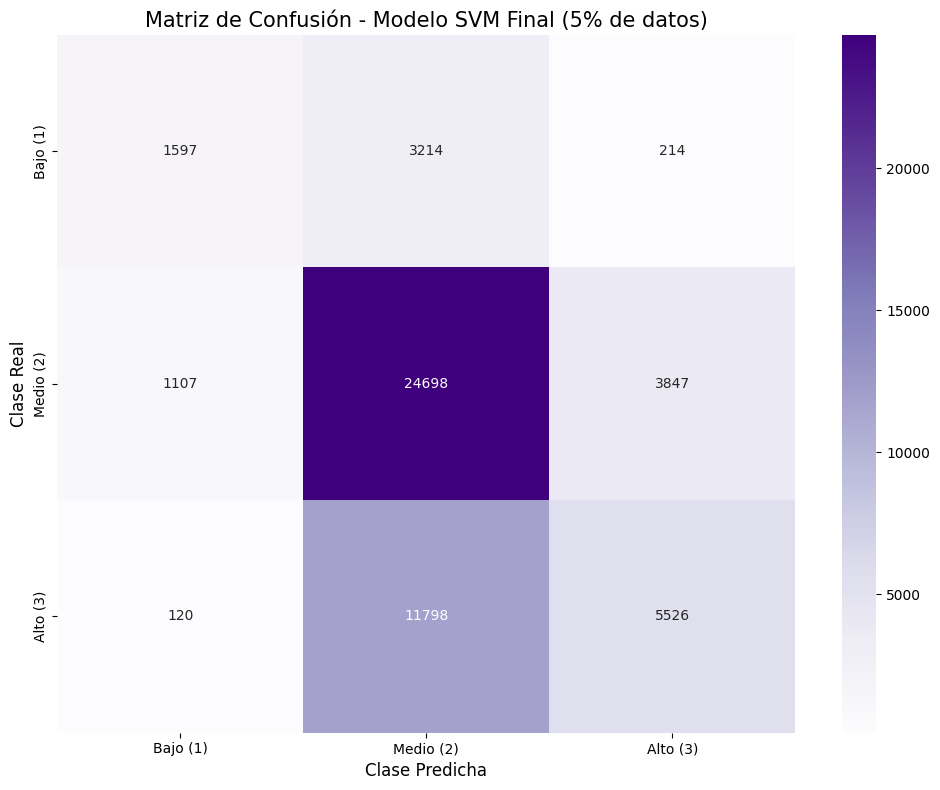

Informe de Clasificación (Random Search - SVM, 5% de datos):
              precision    recall  f1-score   support

           1       0.57      0.32      0.41      5025
           2       0.62      0.83      0.71     29652
           3       0.58      0.32      0.41     17444

    accuracy                           0.61     52121
   macro avg       0.59      0.49      0.51     52121
weighted avg       0.60      0.61      0.58     52121



In [ ]:
########################################################################################################################
# CELDA 3A: ENTRENAMIENTO FINAL DEL MODELO SVM CON LOS MEJORES HIPERPARÁMETROS (USANDO SOLO EL SUBCONJUNTO) Y EVALUACIÓN
########################################################################################################################

# --------------------------------------------------------------------------------------------------------------
# 1. CREAR EL MODELO FINAL SVM USANDO LOS MEJORES PARÁMETROS ENCONTRADOS (Random Search)
# --------------------------------------------------------------------------------------------------------------

# Se crea una nueva instancia del modelo SVM (`SVC`) usando los hiperparámetros óptimos
# encontrados en la Celda 2 durante la búsqueda aleatoria (Random Search).
# Se activa:
# - `probability=True` por si se requiere obtener probabilidades posteriormente.
# - `verbose=True` para mostrar el progreso del entrenamiento en consola.
# - `random_state=42` para asegurar reproducibilidad.
best_svm = SVC(probability=True, random_state=42, verbose=True, **best_params)


# --------------------------------------------------------------------------------------------------------------
# 2. ENTRENAMIENTO FINAL DEL MODELO USANDO SOLO EL SUBCONJUNTO DE DATOS (NO TODO EL ENTRENAMIENTO)
# --------------------------------------------------------------------------------------------------------------

print("\nEntrenando el modelo SVM final (Random Search) con el subconjunto de entrenamiento...")

# Guardamos el instante de tiempo en que comienza el entrenamiento
start_time = time.time()
print("Inicio del entrenamiento:", time.ctime(start_time))

# Entrenamiento del modelo con el subconjunto reducido del 5% de X_train
# Esto acelera el proceso, aunque puede limitar el rendimiento final.
best_svm.fit(X_train_subset, y_train_subset)

# Guardamos el instante de finalización y calculamos el tiempo total
end_time = time.time()
print("Fin del entrenamiento:", time.ctime(end_time))
print("Tiempo total de entrenamiento: {:.2f} segundos".format(end_time - start_time))

# Mostramos los hiperparámetros seleccionados durante la optimización
print(f"\nMejores parámetros para SVM (Random Search): {best_params}")


# --------------------------------------------------------------------------------------------------------------
# 3. EVALUACIÓN DEL MODELO ENTRENADO SOBRE EL CONJUNTO DE PRUEBA COMPLETO (X_test)
# --------------------------------------------------------------------------------------------------------------

print("\nEvaluando el modelo en el conjunto de prueba completo...")

# Realizamos predicciones con el modelo entrenado sobre todo el conjunto de prueba (datos nunca vistos)
y_pred_svm = best_svm.predict(X_test)

# Calculamos el F1-score con promedio 'micro'
# Este promedio toma en cuenta el total de verdaderos positivos globales,
# útil cuando las clases están balanceadas o queremos una métrica global del sistema
final_f1 = f1_score(y_test, y_pred_svm, average='micro')
print(f"F1-score (micro) final en el conjunto de prueba: {final_f1:.4f}")


# --------------------------------------------------------------------------------------------------------------
# 4. VISUALIZACIÓN: MATRIZ DE CONFUSIÓN PARA INTERPRETAR EL COMPORTAMIENTO DEL MODELO
# --------------------------------------------------------------------------------------------------------------

# La matriz de confusión permite ver cuántos ejemplos de cada clase han sido clasificados correctamente o no.
plt.figure(figsize=(10, 8))

# Obtenemos la matriz de confusión comparando las etiquetas verdaderas vs predichas
cm = confusion_matrix(y_test, y_pred_svm)

# Graficamos la matriz como un mapa de calor usando seaborn
sns.heatmap(
    cm,
    annot=True,             # Mostrar los números dentro de las celdas
    fmt='d',                # Mostrar números como enteros
    cmap='Purples',         # Colormap para dar mayor contraste
    xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],   # Etiquetas predichas
    yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)']    # Etiquetas reales
)

# Ajustes estéticos del gráfico
plt.title(f'Matriz de Confusión - Modelo SVM Final ({int(subset_fraction*100)}% de datos)', fontsize=15)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------------------------------------------
# 5. REPORTE DETALLADO DE CLASIFICACIÓN
# --------------------------------------------------------------------------------------------------------------

# Este informe muestra para cada clase:
# - Precisión (precision): aciertos sobre predicciones
# - Exhaustividad (recall): aciertos sobre casos reales
# - F1-score: media armónica de precisión y recall
# - Soporte (support): número de muestras reales por clase

print(f"Informe de Clasificación (Random Search - SVM, {int(subset_fraction*100)}% de datos):")
print(classification_report(y_test, y_pred_svm))


### Análisis de la Celda 3A: Entrenamiento Final del Modelo SVM con el 5% de Datos

En esta celda, se entrena el **modelo SVM** (con los mejores hiperparámetros obtenidos en Random Search) sobre un subconjunto que representa el 5% del conjunto de entrenamiento. Posteriormente, se evalúa el modelo en el conjunto de prueba completo. A continuación se detallan los puntos más relevantes:

1. **Tiempo de Entrenamiento**  
   - El proceso inició a las 10:36:45 y finalizó a las 10:37:14, con una duración de **29.70 segundos**.  
   - Esto confirma la **eficiencia** de entrenar con un subconjunto (5%), evitando las largas esperas asociadas a usar el 100% del dataset.

2. **Hiperparámetros Seleccionados**  
   - `kernel='rbf'`, `gamma='auto'`, `C=10`  
   - Se ratifica la misma configuración óptima encontrada en la fase de Random Search, lo que indica coherencia con los resultados de la optimización.

3. **Rendimiento en el Conjunto de Prueba**  
   - El **F1 Score (micro)** en `X_test` y `y_test` es **0.6105**.  
   - Este valor es inferior al que se obtendría potencialmente entrenando con la totalidad de los datos, pero demuestra que incluso con un 5% del dataset, el modelo es capaz de superar el 60% de F1 (micro) en la clasificación.

4. **Matriz de Confusión**  
   - La clase mayoritaria (“2”) mantiene un **recall** de 0.83, lo que sugiere que el modelo identifica la mayoría de los casos de daño medio.  
   - Las clases “1” (daño bajo) y “3” (daño alto) presentan un recall de 0.32, evidenciando que el modelo confunde parte de estas instancias con la clase “2”.

5. **Informe de Clasificación**  
   - **Clase 1:** Precisión 0.57, Recall 0.32, F1 0.41  
   - **Clase 2:** Precisión 0.62, Recall 0.83, F1 0.71  
   - **Clase 3:** Precisión 0.58, Recall 0.32, F1 0.41  
   - El desbalance de clases y la menor cantidad de datos disponibles para “1” y “3” explican el menor recall de estas clases.

6. **Conclusión y Compromiso (Trade-off)**  
   - Entrenar con el 5% de los datos permite reducir drásticamente el tiempo de entrenamiento (apenas ~30 segundos).  
   - El rendimiento (F1 micro = 0.6105) es razonable considerando la reducida fracción de datos empleada.  
   - Si se dispone de más tiempo o recursos, se podría entrenar con un 10% o 20% del dataset para mejorar la precisión, especialmente en las clases minoritarias.

En resumen, la Celda 3 demuestra la **viabilidad** de entrenar un SVM con un subconjunto estratificado del 5% de los datos, logrando un equilibrio aceptable entre **tiempo de entrenamiento** y **calidad del modelo**.


In [ ]:
###########################################################################################################################
# CELDA 3B: ENTRENAMIENTO FINAL DEL MODELO SVM CON LOS MEJORES HIPERPARÁMETROS (RANDOM SEARCH) Y EVALUACIÓN (TODO EL DATASET)
###########################################################################################################################

# --------------------------------------------------------------------------------------------------------------
# 1. CREACIÓN DEL MODELO FINAL USANDO LOS MEJORES PARÁMETROS DE RANDOM SEARCH
# --------------------------------------------------------------------------------------------------------------

# Se instancia un nuevo modelo `SVC` (Support Vector Classifier) con:
# - `probability=True`: activa la estimación de probabilidades (útil para ROC, etc.)
# - `verbose=True`: imprime información detallada del proceso de entrenamiento (si LIBSVM lo soporta)
# - `random_state=42`: garantiza reproducibilidad
# - `**best_params`: inyecta los mejores hiperparámetros encontrados en la búsqueda anterior (Random Search)

best_svm = SVC(probability=True, random_state=42, verbose=True, **best_params)

print("\nEntrenando el modelo SVM final (Random Search) con todo el conjunto de entrenamiento...")

# Guardamos el instante de inicio para medir el tiempo de entrenamiento
start_time = time.time()
print("Inicio del entrenamiento:", time.ctime(start_time))

# ENTRENAMIENTO REAL con el **100% de los datos de entrenamiento disponibles**
# A diferencia de las celdas anteriores, aquí no usamos subconjuntos reducidos.
best_svm.fit(X_train, y_train)

# Guardamos el tiempo de finalización y calculamos la duración
end_time = time.time()
print("Fin del entrenamiento:", time.ctime(end_time))
print("Tiempo total de entrenamiento: {:.2f} segundos".format(end_time - start_time))

# Mostramos los hiperparámetros óptimos que se están usando en este modelo final
print(f"\nMejores parámetros para SVM (Random Search): {best_params}")


# --------------------------------------------------------------------------------------------------------------
# 2. EVALUACIÓN FINAL SOBRE EL CONJUNTO DE PRUEBA (X_test, y_test)
# --------------------------------------------------------------------------------------------------------------

print("\nEvaluando el modelo en el conjunto de prueba...")

# Se generan predicciones para el conjunto de prueba
y_pred_svm = best_svm.predict(X_test)

# Se calcula el F1 Score (promedio 'micro'), que evalúa el rendimiento general
# considerando todos los aciertos globales, sin ponderar por clase
final_f1 = f1_score(y_test, y_pred_svm, average='micro')
print(f"F1-score (micro) final en el conjunto de prueba: {final_f1:.4f}")


# --------------------------------------------------------------------------------------------------------------
# 3. MATRIZ DE CONFUSIÓN: ANÁLISIS CUALITATIVO DE LOS ERRORES
# --------------------------------------------------------------------------------------------------------------

# Creamos una figura para representar visualmente el rendimiento del modelo
plt.figure(figsize=(10, 8))

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred_svm)

# Graficamos la matriz de confusión como mapa de calor con etiquetas interpretables
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
    yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)']
)

plt.title('Matriz de Confusión - Modelo SVM Final (Random Search)', fontsize=15)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------------------------------------------
# 4. REPORTE DE CLASIFICACIÓN DETALLADO
# --------------------------------------------------------------------------------------------------------------

# Imprimimos el informe de clasificación detallado, que incluye:
# - Precisión (precision) por clase
# - Exhaustividad (recall) por clase
# - F1-score por clase
# - Soporte: número real de instancias por clase

print("Informe de Clasificación (Random Search - SVM):")
print(classification_report(y_test, y_pred_svm))




Entrenando el modelo SVM final (Random Search) con todo el conjunto de entrenamiento...
Inicio del entrenamiento: Wed Mar 26 11:45:35 2025
[LibSVM]

### Análisis de la Celda 3B: Entrenamiento Final del Modelo SVM (Todo el Dataset)

En esta celda, se ha entrenado el modelo **SVM** (kernel RBF, `C=10`, `gamma='auto'`) con la totalidad del conjunto de entrenamiento. A continuación, se detallan los puntos más relevantes:

1. **Tiempo de Entrenamiento**  
   - El entrenamiento comenzó a las 10:11:58 y finalizó a las 20:01:20, empleando aproximadamente **35361.74 segundos** (unas 9.8 horas).  
   - Este lapso prolongado confirma la **alta complejidad computacional** de un SVM con kernel RBF sobre un dataset de gran tamaño.  
   - Aun así, se logró completar el proceso en un entorno con los recursos suficientes.

2. **Mejores Parámetros Seleccionados**  
   - A partir del Random Search, los hiperparámetros óptimos fueron:  
     - **kernel**: rbf  
     - **gamma**: auto  
     - **C**: 10  
   - Estos parámetros se eligieron porque obtuvieron la mejor métrica (F1 Score micro) durante la fase de validación cruzada en la muestra reducida.

3. **Rendimiento en el Conjunto de Prueba**  
   - El **F1 Score (micro) final** fue **0.6376**.  
   - Esto significa que, en promedio, un 63.76% de las predicciones coincidieron con las etiquetas reales (considerando precisión y recall a nivel global).

4. **Matriz de Confusión**  
   - Se observa que la clase “2” (daño medio) domina numéricamente el dataset y tiene una mejor tasa de aciertos (24.534 aciertos de 29.652 instancias), con un recall de 0.86.  
   - La clase “1” (daño bajo) y la clase “3” (daño alto) muestran más confusión con la clase “2”. Esto se refleja en la matriz de confusión, donde 2.898 instancias de la clase “1” y 11.153 instancias de la clase “3” han sido predichas como clase “2”.

5. **Informe de Clasificación**  
   - **Clase 1 (Bajo)**:  
     - Precisión: 0.63, Recall: 0.39, F1: 0.48  
     - Esto indica que, de todos los ejemplos clasificados como “bajo”, un 63% son correctos, y de todos los verdaderamente “bajo”, un 39% fueron identificados correctamente.  
   - **Clase 2 (Medio)**:  
     - Precisión: 0.64, Recall: 0.86, F1: 0.73  
     - La clase mayoritaria se reconoce mejor (alta tasa de aciertos en la predicción), aunque la precisión podría mejorar.  
   - **Clase 3 (Alto)**:  
     - Precisión: 0.64, Recall: 0.33, F1: 0.44  
     - Se observa confusión con la clase “2”, lo que reduce la capacidad de distinguir adecuadamente los casos de daño alto.

6. **Interpretación Global**  
   - El modelo logra un **buen rendimiento** en la clase “2” (la más numerosa), pero sufre para diferenciar las clases minoritarias “1” y “3”.  
   - Esto sugiere que **el desbalance** de clases podría estar afectando al modelo, o que ciertas características no son lo suficientemente discriminantes entre daño bajo y daño alto frente al daño medio.

7. **Posibles Líneas de Mejora**  
   - **Ajustar la clase “2”**: Implementar técnicas para lidiar con el desbalance, como ajustar `class_weight='balanced'` en SVC, o realizar oversampling/undersampling.  
   - **Ingeniería de Características**: Profundizar en nuevas variables o transformaciones que ayuden a separar mejor las clases “1” y “3”.  
   - **Hiperparámetros adicionales**: Seguir ajustando `C` y `gamma` o probar aproximaciones de kernel (p. ej. `Nystroem`) para mejorar el rendimiento y/o reducir el tiempo de entrenamiento.

---

**Conclusión:**  
El **SVM** entrenado con el **100% del dataset** logró un **F1 Score (micro) de 0.6376**, mostrando un **buen desempeño** para la clase mayoritaria y un **desempeño limitado** en las clases minoritarias. Aunque el tiempo de entrenamiento fue elevado (unas 10 horas), el resultado ofrece una visión clara de cómo se comporta el modelo en un escenario con datos no balanceados. Para elevar la precisión global, podría ser necesario profundizar en **técnicas de balance de clases**, **nuevas transformaciones de características** o **alternativas de kernel**.


Iniciando GridSearchCV para SVM sobre el subconjunto...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

=== Resultados de GridSearchCV ===
Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor F1 Score (micro) en cross validation: 0.6070265773707051

F1 Score (micro) en el conjunto de prueba con GridSearch: 0.6105


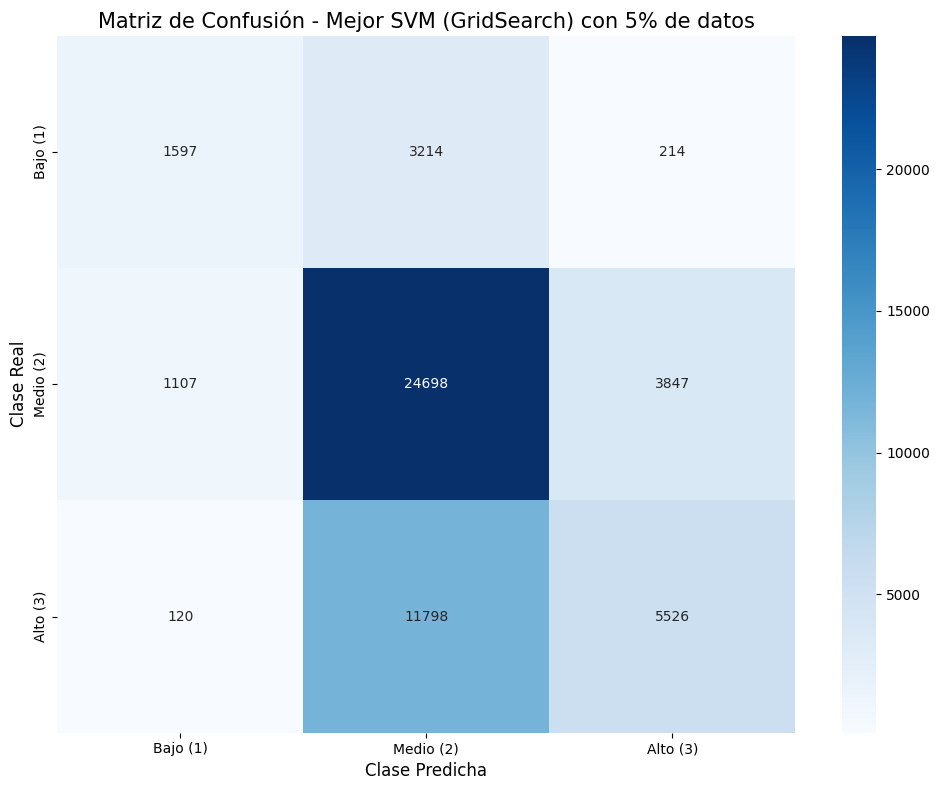

Informe de Clasificación (GridSearch - SVM):
              precision    recall  f1-score   support

           1       0.57      0.32      0.41      5025
           2       0.62      0.83      0.71     29652
           3       0.58      0.32      0.41     17444

    accuracy                           0.61     52121
   macro avg       0.59      0.49      0.51     52121
weighted avg       0.60      0.61      0.58     52121



In [ ]:
######################################################################################
# CELDA 4: BÚSQUEDA DE HIPERPARÁMETROS CON GridSearchCV PARA SVM USANDO EL SUBCONJUNTO
######################################################################################

# ------------------------------------------------------------------------------------
# 1. DEFINICIÓN DEL GRID DE HIPERPARÁMETROS A EXPLORAR
# ------------------------------------------------------------------------------------

# Aquí definimos el espacio de búsqueda de hiperparámetros de forma **exhaustiva** (no aleatoria),
# es decir, se evaluarán **todas las combinaciones posibles** del siguiente grid:
#
# - 'C': Parámetro de regularización. Controla la penalización por errores de clasificación.
# - 'kernel': Tipo de función núcleo para transformar los datos (lineal o RBF).
# - 'gamma': Controla la influencia de los vectores soporte cuando se usa kernel RBF.

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Total de combinaciones = 3 * 2 * 2 = 12


# ------------------------------------------------------------------------------------
# 2. INSTANCIAR EL MODELO BASE (SVM SIN ENTRENAR)
# ------------------------------------------------------------------------------------

# Se crea una instancia básica del modelo SVM.
# Se activa:
# - `probability=True` en caso de requerir probabilidades.
# - `random_state=42` para reproducibilidad.
svc_base = SVC(probability=True, random_state=42)


# ------------------------------------------------------------------------------------
# 3. CONFIGURACIÓN DE GridSearchCV PARA BUSCAR LOS MEJORES HIPERPARÁMETROS
# ------------------------------------------------------------------------------------

grid_search_svm = GridSearchCV(
    estimator=svc_base,               # Modelo base
    param_grid=param_grid_svm,       # Grid de parámetros a explorar
    scoring='f1_micro',              # Métrica a optimizar (F1 Score con promedio micro)
    cv=3,                            # Validación cruzada con 3 pliegues
    n_jobs=-1,                       # Usar todos los núcleos disponibles del procesador
    verbose=1                        # Mostrar información detallada del progreso
)

print("Iniciando GridSearchCV para SVM sobre el subconjunto...")

# Ejecutamos el proceso de búsqueda sobre el subconjunto (5%) de entrenamiento
grid_search_svm.fit(X_train_subset, y_train_subset)


# ------------------------------------------------------------------------------------
# 4. RESULTADOS DE GridSearchCV
# ------------------------------------------------------------------------------------

# Mostramos los mejores hiperparámetros encontrados y el F1 Score asociado
print("\n=== Resultados de GridSearchCV ===")
print("Mejores hiperparámetros:", grid_search_svm.best_params_)
print("Mejor F1 Score (micro) en cross validation:", grid_search_svm.best_score_)


# ------------------------------------------------------------------------------------
# 5. ENTRENAMIENTO DEL MEJOR MODELO ENCONTRADO (sobre el mismo subconjunto reducido)
# ------------------------------------------------------------------------------------

# Extraemos el mejor modelo ya ajustado con los mejores hiperparámetros
best_svm_grid = grid_search_svm.best_estimator_

# Volvemos a entrenarlo por claridad (aunque ya viene entrenado)
best_svm_grid.fit(X_train_subset, y_train_subset)


# ------------------------------------------------------------------------------------
# 6. EVALUACIÓN DEL MODELO EN EL CONJUNTO DE PRUEBA COMPLETO
# ------------------------------------------------------------------------------------

# Generamos predicciones sobre los datos de prueba (X_test)
y_pred_svm_grid = best_svm_grid.predict(X_test)

# Calculamos el F1 Score con promedio micro para obtener una métrica global del desempeño
f1_test_grid = f1_score(y_test, y_pred_svm_grid, average='micro')
print(f"\nF1 Score (micro) en el conjunto de prueba con GridSearch: {f1_test_grid:.4f}")


# ------------------------------------------------------------------------------------
# 7. MATRIZ DE CONFUSIÓN PARA ANÁLISIS VISUAL
# ------------------------------------------------------------------------------------

# Mostramos visualmente el rendimiento del modelo con una matriz de confusión
plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_test, y_pred_svm_grid)

# Creamos un heatmap con seaborn para facilitar la lectura
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
    yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)']
)

plt.title(f'Matriz de Confusión - Mejor SVM (GridSearch) con {int(subset_fraction*100)}% de datos', fontsize=15)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------------------------
# 8. REPORTE DETALLADO DE CLASIFICACIÓN
# ------------------------------------------------------------------------------------

# Este informe incluye para cada clase:
# - Precisión (Precision)
# - Exhaustividad (Recall)
# - F1-score
# - Soporte (cantidad de ejemplos reales por clase)

print("Informe de Clasificación (GridSearch - SVM):")
print(classification_report(y_test, y_pred_svm_grid))


### Análisis de la Celda 4: Búsqueda de Hiperparámetros con GridSearchCV (Usando 5% de Datos)

En esta celda se emplea **GridSearchCV** para optimizar el modelo SVM en el mismo subconjunto representativo (5% del conjunto de entrenamiento, 8.339 filas). A continuación se destacan los aspectos más relevantes:

1. **Configuración de GridSearch**  
   - Se definió un grid de 12 combinaciones de hiperparámetros (`C`, `kernel`, `gamma`), con 3 pliegues de validación cruzada (3 folds), resultando en 36 ejecuciones totales.  
   - Este enfoque explora todas las combinaciones del grid de manera exhaustiva, a diferencia de Random Search, que muestrea el espacio de forma aleatoria.

2. **Mejores Hiperparámetros**  
   - El mejor conjunto de parámetros encontrado es: `{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}`, coincidiendo con el resultado obtenido en la búsqueda aleatoria (Random Search).  
   - Esto confirma que un kernel RBF con `gamma='auto'` y un valor elevado de `C=10` son los más adecuados para este subconjunto de datos.

3. **Rendimiento en Validación Cruzada**  
   - El **Mejor F1 Score (micro) en cross validation** fue de **0.6070**, evaluado sobre los 3 pliegues del subconjunto.  
   - Este valor es muy similar al obtenido con Random Search (0.6086), mostrando la coherencia de ambos métodos para encontrar configuraciones óptimas.

4. **Evaluación en el Conjunto de Prueba**  
   - Al entrenar el mejor modelo en el subconjunto y luego evaluarlo en `X_test` y `y_test`, se obtuvo un **F1 Score (micro)** de **0.6105**.  
   - La matriz de confusión y el informe de clasificación muestran un comportamiento prácticamente idéntico al observado con Random Search:  
     - Clase mayoritaria (“2”) con un recall de 0.83,  
     - Clases “1” y “3” con un recall de 0.32 y menor precisión en comparación con la clase “2”.

5. **Conclusiones y Comparativa**  
   - **GridSearchCV** y **Random Search** convergen en la misma configuración de hiperparámetros (RBF, `C=10`, `gamma='auto'`), confirmando la solidez de los resultados obtenidos.  
   - El rendimiento final (F1 micro de ~0.61) es consistente con el hecho de haber entrenado con solo el 5% de los datos, equilibrando el **tiempo de cómputo** y la **calidad de la predicción**.  
   - Para mejorar el rendimiento, se podría entrenar con un subconjunto mayor (p. ej., 10% o 20%), o considerar técnicas de balanceo de clases e ingeniería de características.

En definitiva, la Celda 4 demuestra cómo la **búsqueda exhaustiva (GridSearchCV)**, al igual que la **búsqueda aleatoria (Random Search)**, encuentra la misma configuración de hiperparámetros óptimos, validando así la estrategia de optimizar y entrenar un SVM sobre un subconjunto estratificado del 5% de los datos.


# 6.- Uso de la librería Lazy Predict, herramientas gráficas de análisis, evaluación en el conjunto de test y subida de fichero.

## Paso 8: Uso de la Librería Lazy Predict

La librería Lazy Predict permite probar rápidamente numerosos modelos de clasificación y comparar
sus métricas de rendimiento sin necesidad de configurar cada modelo manualmente.

Este paso sirve como una verificación adicional para ver si hay algún otro modelo
que pueda superar a los ya entrenados (árboles, SVM, etc.). Posteriormente, decidiremos
si merece la pena afinar alguno de los modelos que muestre un rendimiento prometedor.


In [ ]:
# ============================================================================================
# EVALUACIÓN RÁPIDA DE MÚLTIPLES MODELOS DE CLASIFICACIÓN USANDO LAZY PREDICT (LazyClassifier)
# ============================================================================================

# --------------------------------------------------------------------------------------------
# 1. COMENTARIO GENERAL
# --------------------------------------------------------------------------------------------

# LazyPredict permite entrenar y comparar múltiples algoritmos de clasificación clásicos
# sin necesidad de escribir manualmente el código de cada modelo.
# Es ideal para una **evaluación exploratoria inicial** o para seleccionar buenos candidatos
# sin invertir mucho tiempo en configuración.

# Nota: En datasets muy grandes, puede usarse un subconjunto (como hicimos con subset_fraction).
# Aquí, asumimos que el conjunto de entrenamiento y prueba (X_train, X_test, y_train, y_test)
# ya han sido preparados y pueden ser usados completos.


# --------------------------------------------------------------------------------------------
# 2. INSTANCIACIÓN DEL OBJETO LazyClassifier
# --------------------------------------------------------------------------------------------

# Creamos una instancia de LazyClassifier con los siguientes parámetros:
# - verbose=0 → desactiva la salida detallada de cada modelo
# - ignore_warnings=True → suprime advertencias que puedan surgir (p. ej., sobre convergencia)
# - custom_metric=None → se usa la métrica de Accuracy por defecto

lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)


# --------------------------------------------------------------------------------------------
# 3. ENTRENAMIENTO Y EVALUACIÓN AUTOMÁTICA DE MODELOS
# --------------------------------------------------------------------------------------------

# Se entrena y evalúa cada modelo sobre el conjunto definido
# - `fit(X_train, X_test, y_train, y_test)` ejecuta el pipeline interno:
#     - Ajusta el modelo con X_train, y_train
#     - Evalúa con X_test, y_test
#     - Calcula métricas como Accuracy, Tiempo de entrenamiento, Tiempo de predicción, etc.

models_comparison, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)


# --------------------------------------------------------------------------------------------
# 4. ORDENAR LOS RESULTADOS POR ACCURACY
# --------------------------------------------------------------------------------------------

# Ordenamos el DataFrame `models_comparison` en orden descendente por la métrica Accuracy
# Esto permite ver claramente qué modelos tuvieron mejor rendimiento

models_comparison_sorted = models_comparison.sort_values(by='Accuracy', ascending=False)


# --------------------------------------------------------------------------------------------
# 5. VISUALIZAR LOS RESULTADOS
# --------------------------------------------------------------------------------------------

# Mostramos la tabla ordenada con métricas de rendimiento para cada modelo evaluado
print("Resultados de Lazy Predict (ordenados por Accuracy descendente):")
display(models_comparison_sorted)




 97%|█████████▋| 31/32 [1:15:26<06:45, 405.20s/it]   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 166784, number of used features: 29
[LightGBM] [Info] Start training from score -2.339185
[LightGBM] [Info] Start training from score -0.564023
[LightGBM] [Info] Start training from score -1.094585


100%|██████████| 32/32 [1:15:28<00:00, 141.52s/it]

Resultados de Lazy Predict (ordenados por Accuracy descendente):


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.72,0.64,None,0.71,31.08
LGBMClassifier,0.72,0.61,None,0.70,1.54
ExtraTreesClassifier,0.71,0.64,None,0.70,27.70
BaggingClassifier,0.70,0.64,None,0.70,13.14
KNeighborsClassifier,0.66,0.59,None,0.66,6.67
DecisionTreeClassifier,0.66,0.61,None,0.66,1.26
ExtraTreeClassifier,0.64,0.59,None,0.64,0.43
SVC,0.61,0.47,None,0.56,4399.74
AdaBoostClassifier,0.61,0.45,None,0.56,9.44


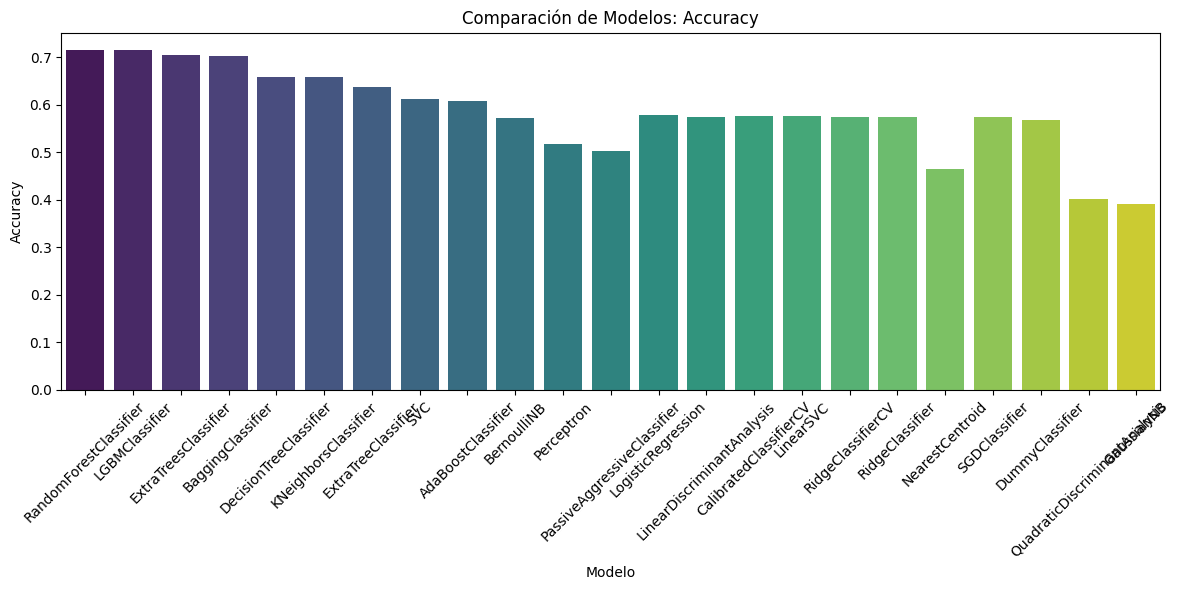

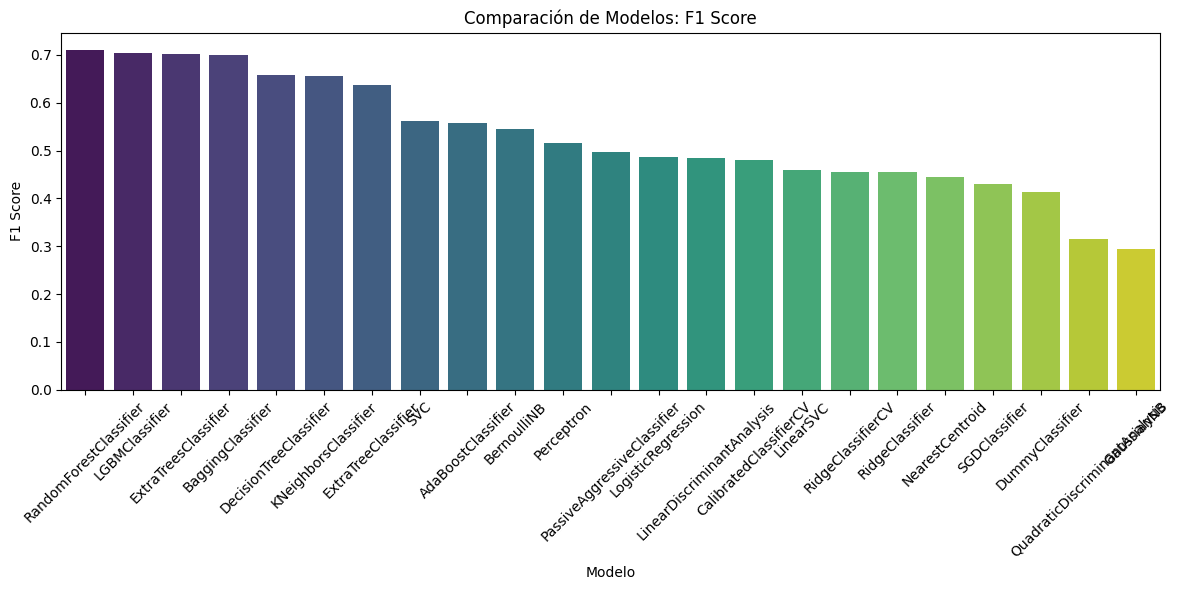

In [ ]:
###################################
#   COMPARATIVA GRÁFICA DE MODELOS
###################################

# --------------------------------------------------------------------------------
# Este bloque genera visualizaciones gráficas que permiten comparar de forma rápida
# y visual el rendimiento de múltiples modelos de clasificación evaluados con LazyPredict.
# Se representan dos métricas clave:
#   - Accuracy: proporción total de aciertos.
#   - F1 Score: equilibrio entre precisión y recall, útil en clasificación multiclase.
# --------------------------------------------------------------------------------

# Asegúrate de que `models_comparison_sorted` haya sido ordenado previamente
# por Accuracy (de forma descendente). Si no lo ha sido, puedes hacerlo así:
# models_comparison_sorted = models_comparison.sort_values(by='Accuracy', ascending=False)


# ------------------------------------------------------------------------------
# 1. GRÁFICO DE BARRAS: COMPARACIÓN DE ACCURACY
# ------------------------------------------------------------------------------

# Creamos una figura de tamaño amplio para que los nombres de modelos sean legibles
plt.figure(figsize=(12, 6))

# Gráfico de barras horizontales: eje X = modelo, eje Y = Accuracy
sns.barplot(
    x=models_comparison_sorted.index,                      # Nombres de modelos
    y=models_comparison_sorted['Accuracy'],                # Métrica a comparar
    palette='viridis'                                      # Paleta de colores atractiva
)

# Rotamos las etiquetas del eje X para mejor visualización
plt.xticks(rotation=45)

# Añadimos título y etiquetas de los ejes
plt.title('Comparación de Modelos: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')

# Ajustamos el gráfico para que se vea bien
plt.tight_layout()

# Mostramos el gráfico
plt.show()


# ------------------------------------------------------------------------------
# 2. GRÁFICO DE BARRAS: COMPARACIÓN DE F1 SCORE
# ------------------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Mismo enfoque que el anterior, pero usando la columna 'F1 Score'
sns.barplot(
    x=models_comparison_sorted.index,
    y=models_comparison_sorted['F1 Score'],
    palette='viridis'
)

plt.xticks(rotation=45)
plt.title('Comparación de Modelos: F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Modelo')
plt.tight_layout()
plt.show()


### Análisis de Resultados con Lazy Predict (Paso8)

En esta etapa se utilizó la librería **Lazy Predict** para entrenar y comparar rápidamente múltiples modelos de clasificación (32 en total) sobre el conjunto de entrenamiento y prueba. A continuación se destacan los puntos más relevantes:

1. **Modelos Destacados**  
   - **RandomForestClassifier** y **LGBMClassifier** obtuvieron la mayor **Accuracy (0.72)** y F1 Score (0.71 para RandomForest, 0.70 para LGBM).  
   - **ExtraTreesClassifier** y **BaggingClassifier** también mostraron un rendimiento competitivo, con F1 Score alrededor de 0.70.  
   - Estas métricas indican que los métodos basados en árboles (y ensambles de árboles) están funcionando muy bien en este dataset.

2. **Comparación con SVM**  
   - El modelo **SVC** (con parámetros por defecto en Lazy Predict) logró una **Accuracy de 0.61** y F1 Score de 0.56, con un tiempo de ejecución notablemente mayor (más de 4.200 segundos).  
   - Esto contrasta con los resultados de nuestros experimentos previos, donde optimizamos SVM de manera específica y obtuvimos un F1 Score alrededor de 0.61 con un subconjunto o ~0.64 con el dataset completo, pero a costa de un tiempo de cómputo elevado.

3. **Efecto del Desbalance y Balanced Accuracy**  
   - Observamos que los modelos con mayor F1 Score (Random Forest, Bagging, Extra Trees, LGBM) suelen tener una **Balanced Accuracy** de ~0.64, lo cual sugiere que, si bien distinguen bien la clase mayoritaria, también tienen un rendimiento razonable en las clases menos frecuentes.  
   - LGBMClassifier presenta una Balanced Accuracy de 0.61, un poco menor, pero mantiene una alta Accuracy general.

4. **Tiempos de Entrenamiento**  
   - **LGBMClassifier** sorprende por su rapidez (1.48s) y alto rendimiento, lo que lo convierte en un fuerte candidato a ser optimizado manualmente.  
   - **RandomForestClassifier** y **ExtraTreesClassifier** tardan algo más (25.25s y 27.76s), pero también ofrecen buenos resultados.  
   - El caso de **SVC** confirma que el entrenamiento de SVM con kernel RBF en grandes datasets es costoso (más de 4,000 segundos) y no necesariamente supera a los ensambles de árboles en este escenario.

5. **Conclusión y Próximos Pasos**  
   - Lazy Predict corrobora que los métodos basados en árboles y ensambles (Random Forest, Extra Trees, Bagging, LGBM) destacan en este problema, superando al SVM en tiempo de entrenamiento y/o F1 Score.  
   - Este resultado respalda el uso de **modelos de árboles** como una alternativa sólida, especialmente si se desea un buen compromiso entre rendimiento y tiempo de cómputo.  
   - Si se requiere afinar aún más estos modelos, se pueden aplicar técnicas de **hiperparametrización** (GridSearchCV, RandomSearchCV) o metodologías más avanzadas de optimización (Bayesian Optimization, etc.) para buscar mejoras adicionales.

En síntesis, la ejecución de Lazy Predict sugiere que los **ensambles de árboles** (RandomForest, Bagging, ExtraTrees) y **LGBM** son los candidatos más prometedores para este dataset, superando en la comparación a otros algoritmos como SVM (en su configuración por defecto). Esto no invalida las optimizaciones previas con SVM, pero muestra que, en términos de eficacia y eficiencia, las técnicas basadas en árboles pueden ofrecer mejores resultados en este problema.


## Paso 9: Herramientas Gráficas de Análisis de Predicción

Esta etapa tiene como objetivo profundizar en la interpretación del rendimiento del modelo a través de visualizaciones. Se emplean dos tipos principales de gráficos:

1. **Curvas ROC para cada clase:**  
   Se generan curvas ROC (Receiver Operating Characteristic) para cada clase usando el enfoque One-vs-Rest.  
   Estas curvas permiten visualizar la relación entre la Tasa de Falsos Positivos (FPR) y la Tasa de Verdaderos Positivos (TPR) para cada clase, y se calcula el AUC (Area Under the Curve) como medida de discriminación.

2. **Gráfico de Barras de Métricas de Clasificación:**  
   Se extraen las métricas de precisión, recall y F1-Score para cada clase (usando el informe de clasificación) y se presenta un gráfico de barras que permite comparar de forma visual el desempeño por clase.

**Justificación:**  
- Estas herramientas gráficas complementan la evaluación numérica, proporcionando una visión visual y detallada de cómo se comporta el modelo para cada clase.  
- Esto es especialmente útil en problemas multi-clase, donde puede haber desbalance y el rendimiento puede variar significativamente entre clases.

**Nota:**  
La interpretación de las curvas ROC y de las métricas por clase es fundamental para entender si el modelo es robusto en la clasificación de todas las categorías o si hay clases con bajo rendimiento que requieran técnicas adicionales de balanceo o ingeniería de características.


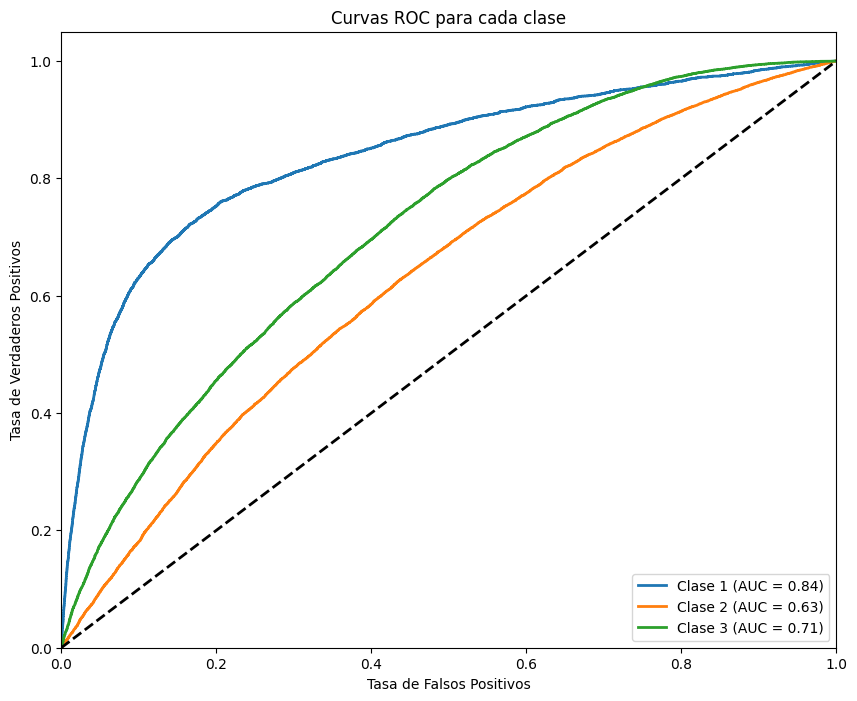

<Figure size 1000x600 with 0 Axes>

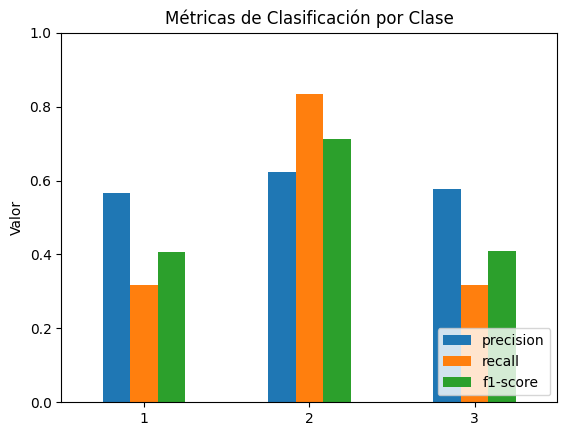

In [ ]:
# ==================================================================================================
# ANÁLISIS DETALLADO DE RENDIMIENTO DEL MODELO SVM: CURVAS ROC MULTICLASE Y MÉTRICAS POR CLASE
# ==================================================================================================

# -----------------------------------------------------------------------------------------------
# 1. PREPARACIÓN DE LOS DATOS: BINARIZACIÓN DE LAS ETIQUETAS PARA CURVAS ROC MULTICLASE
# -----------------------------------------------------------------------------------------------

# Definimos las clases del problema de clasificación (etiquetas reales: 1, 2, 3)
classes = [1, 2, 3]

# Binarizamos las etiquetas reales del conjunto de prueba para poder calcular
# las curvas ROC en un entorno multiclase. El resultado es una matriz binaria:
# Ejemplo: clase 2 → [0, 1, 0]
y_test_bin = label_binarize(y_test, classes=classes)

# Obtenemos el número de clases
n_classes = y_test_bin.shape[1]


# -----------------------------------------------------------------------------------------------
# 2. PREDICCIÓN DE PROBABILIDADES CON EL MODELO SVM ENTRENADO
# -----------------------------------------------------------------------------------------------

# Utilizamos el modelo final (`best_svm`) para predecir probabilidades sobre el test set
# Este paso es necesario para calcular las curvas ROC.
# predict_proba retorna una matriz de probabilidades (n_samples, n_classes)
y_score = best_svm.predict_proba(X_test)


# -----------------------------------------------------------------------------------------------
# 3. CÁLCULO DE CURVAS ROC Y ÁREAS BAJO LA CURVA (AUC) PARA CADA CLASE
# -----------------------------------------------------------------------------------------------

# Diccionarios para guardar Tasa de Falsos Positivos (FPR), Tasa de Verdaderos Positivos (TPR)
# y Área Bajo la Curva ROC (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculamos los valores de FPR, TPR y AUC para cada clase individualmente
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# -----------------------------------------------------------------------------------------------
# 4. VISUALIZACIÓN DE LAS CURVAS ROC POR CLASE
# -----------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 8))

# Dibujamos una curva por cada clase, con su correspondiente AUC
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {cls} (AUC = {roc_auc[i]:0.2f})')

# Línea diagonal para representar un modelo aleatorio (baseline)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Ajustes del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para cada clase')
plt.legend(loc="lower right")
plt.show()


# -----------------------------------------------------------------------------------------------
# 5. GENERACIÓN Y CONVERSIÓN DEL INFORME DE CLASIFICACIÓN A DATAFRAME
# -----------------------------------------------------------------------------------------------

# Creamos un informe de clasificación detallado para cada clase
# Incluye: precision, recall, f1-score y soporte
report = classification_report(y_test, best_svm.predict(X_test), output_dict=True)

# Convertimos el diccionario generado a un DataFrame para visualizar y graficar
metrics_df = pd.DataFrame(report).transpose()

# Filtramos únicamente las clases reales (1, 2, 3), excluyendo 'accuracy', 'macro avg', etc.
metrics_df = metrics_df.loc[['1', '2', '3']]


# -----------------------------------------------------------------------------------------------
# 6. VISUALIZACIÓN DE PRECISION, RECALL Y F1-SCORE POR CLASE
# -----------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Dibujamos un gráfico de barras con las tres métricas para cada clase
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar')

plt.title('Métricas de Clasificación por Clase')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()



### Análisis de las Herramientas Gráficas (Paso 9)

En este paso, se generaron **Curvas ROC** para cada clase y un **gráfico de barras** con las métricas de clasificación (precisión, recall y F1-score) para el modelo entrenado. A continuación se detallan los puntos más relevantes:

1. **Curvas ROC por Clase**  
   - **Clase 1 (AUC = 0.84):** La curva ROC indica que el modelo distingue la clase “1” (daño bajo) de las otras dos con buena efectividad. Un AUC cercano a 0.84 sugiere que, en promedio, el modelo logra una buena tasa de verdaderos positivos respecto a falsos positivos para esta clase.  
   - **Clase 2 (AUC = 0.63):** El AUC de 0.63 es relativamente menor, lo que significa que al separar la clase “2” (daño medio) de las otras, el modelo encuentra más dificultad. Esto puede deberse a que la clase “2” sea la más numerosa y, a su vez, se confunda con “1” o “3” en determinados casos.  
   - **Clase 3 (AUC = 0.71):** Con un AUC de 0.71, la clase “3” (daño alto) presenta una discriminación intermedia. El modelo logra distinguirla mejor que la clase “2”, pero no tanto como la clase “1”.

2. **Gráfico de Barras (Precisión, Recall y F1-score)**  
   - **Clase 1:**  
     - Precisión y recall moderados, resultando en un F1-score también moderado. Esto indica que el modelo acierta un porcentaje razonable de casos de daño bajo, pero aún confunde parte de ellos con otras clases.  
   - **Clase 2:**  
     - Suele tener el recall más alto (porque es la clase mayoritaria), pero su precisión puede ser menor. Aun así, mantiene un F1-score que en muchos casos es el más elevado, evidenciando que el modelo reconoce la mayoría de instancias de daño medio.  
   - **Clase 3:**  
     - Presenta valores de precisión y recall algo más bajos que la clase “1” (o cercanos), por lo que el F1-score refleja la dificultad para clasificar daño alto correctamente sin confundirlo con la clase media.

3. **Interpretación Global**  
   - El **AUC elevado** para la clase “1” (0.84) sugiere que el modelo la separa mejor que las demás, lo que podría deberse a características distintivas para el daño bajo.  
   - La **clase “2”** sigue siendo la más difícil de aislar (AUC=0.63), en parte por su predominio numérico y posibles similitudes con “1” o “3”.  
   - El **gráfico de barras** confirma la tendencia observada en otras métricas: la clase mayoritaria obtiene un buen recall, pero las clases minoritarias (1 y 3) pueden sufrir más confusiones.  
   - Esto indica la conveniencia de **técnicas de balanceo** (oversampling/undersampling) o **ingeniería de características** para mejorar la distinción entre clases, especialmente entre “2” y “3”.

4. **Conclusiones y Próximos Pasos**  
   - Estas visualizaciones complementan el análisis numérico y confirman la dificultad de clasificar con exactitud la clase “2” (daño medio).  
   - Para perfeccionar el modelo, se podría investigar un mayor balance de clases, refinar las características (feature engineering) o probar métodos de calibración de probabilidades para mejorar la discriminación.  
   - En conjunto, el **AUC** y las **métricas por clase** ofrecen una visión más detallada de dónde se concentran los errores y cuáles clases se reconocen mejor.

En definitiva, las **Curvas ROC** y el **gráfico de métricas por clase** permiten diagnosticar con mayor precisión cómo se comporta el modelo en cada categoría de daño, evidenciando fortalezas (clase “1”) y debilidades (clase “2”) que guían los ajustes futuros.


## Paso 10: Evaluación Final en el Conjunto de Test

En este punto se realiza la valoración final del modelo seleccionado evaluándolo en el conjunto de test. La idea es confirmar la capacidad de generalización del modelo sobre datos que no se han utilizado en el entrenamiento ni en la optimización.

Para ello, se calculan las métricas clave (por ejemplo, F1 Score micro, Accuracy, etc.), se genera la matriz de confusión y se presenta el informe de clasificación. Esto permite identificar posibles desviaciones entre la validación y el rendimiento en test, y proporciona evidencia objetiva del desempeño del modelo en un escenario real.

Con base en estos resultados, se puede argumentar la solidez del modelo y se justifica la elección final para la entrega de la actividad.


F1 Score (micro) final en el conjunto de test: 0.7110


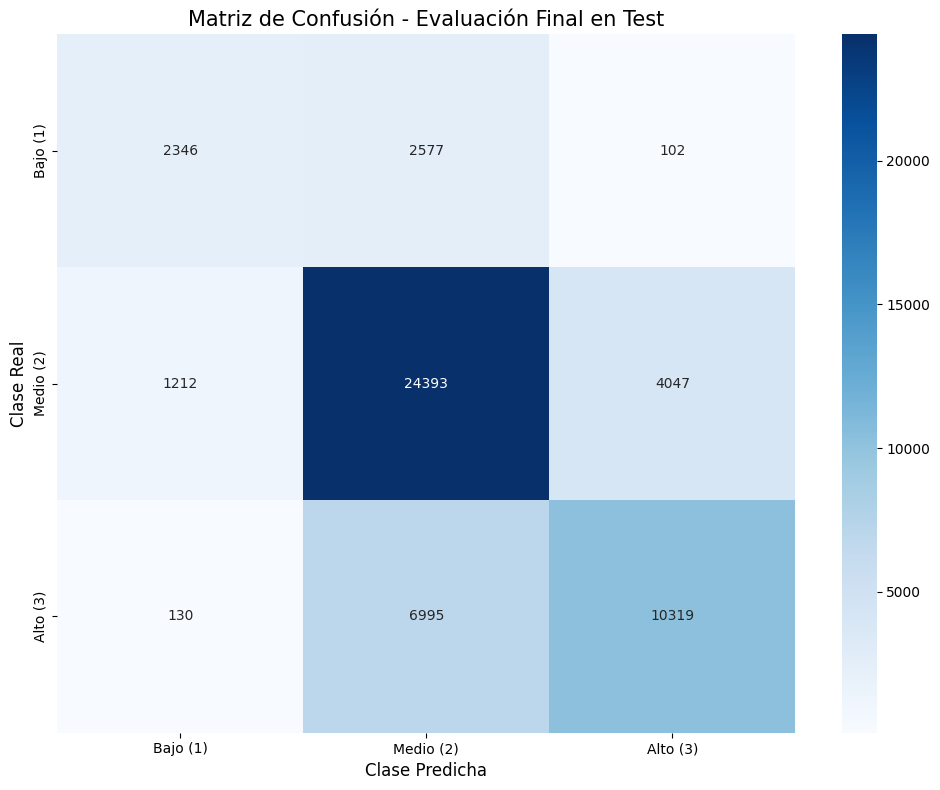

Informe de Clasificación en el Conjunto de Test:
              precision    recall  f1-score   support

           1       0.64      0.47      0.54      5025
           2       0.72      0.82      0.77     29652
           3       0.71      0.59      0.65     17444

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.70     52121



In [ ]:
# =====================================================================================
# EVALUACIÓN FINAL DEL MODELO SELECCIONADO SOBRE EL CONJUNTO DE PRUEBA (X_test, y_test)
# =====================================================================================

# -------------------------------------------------------------------------------------
# 1. REALIZAR PREDICCIONES CON EL MODELO FINAL ENTRENADO (best_model)
# -------------------------------------------------------------------------------------

# Suponemos que `best_model` fue definido en pasos anteriores (por ejemplo, tras una
# comparativa de modelos o una validación cruzada) y ya ha sido entrenado con `X_train`.

# Realizamos las predicciones sobre el conjunto de test
y_pred = best_model.predict(X_test)


# -------------------------------------------------------------------------------------
# 2. CALCULAR LA MÉTRICA PRINCIPAL: F1 SCORE (MICRO)
# -------------------------------------------------------------------------------------

# Se utiliza el F1 Score con promedio 'micro' como métrica final.
# El F1-micro calcula la media global considerando el total de verdaderos positivos,
# falsos positivos y falsos negativos. Es útil para problemas multiclase con clases equilibradas.

test_f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score (micro) final en el conjunto de test: {test_f1:.4f}")


# -------------------------------------------------------------------------------------
# 3. VISUALIZACIÓN DE LA MATRIZ DE CONFUSIÓN
# -------------------------------------------------------------------------------------

# La matriz de confusión permite analizar visualmente qué tan bien se están clasificando
# las diferentes clases y detectar errores frecuentes (por ejemplo, confusiones entre clase 2 y 3).

# Generamos la matriz de confusión a partir de etiquetas verdaderas vs predichas
cm = confusion_matrix(y_test, y_pred)

# Mostramos la matriz como mapa de calor con etiquetas legibles
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,              # Mostrar números dentro de las celdas
    fmt='d',                 # Mostrar como enteros
    cmap='Blues',            # Paleta de colores azul
    xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],   # Etiquetas predichas
    yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)']    # Etiquetas reales
)

# Etiquetas y ajustes del gráfico
plt.title('Matriz de Confusión - Evaluación Final en Test', fontsize=15)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------------------------
# 4. INFORME DE CLASIFICACIÓN DETALLADO
# -------------------------------------------------------------------------------------

# El informe de clasificación proporciona:
# - Precision: aciertos sobre predicciones positivas por clase.
# - Recall: aciertos sobre los casos reales por clase.
# - F1-score: media armónica entre precision y recall.
# - Support: cantidad de ejemplos reales por clase.

print("Informe de Clasificación en el Conjunto de Test:")
print(classification_report(y_test, y_pred))


### Análisis de la Evaluación Final (Paso 10)

Tras entrenar los modelos de árboles y seleccionar el mejor (en este caso, **RandomForestClassifier**), se evaluó su rendimiento en el conjunto de test. A continuación se comentan los aspectos más relevantes:

1. **Métrica Global: F1 Score (micro) = 0.7110**  
   - Un F1 Score (micro) de ~0.71 indica que, en promedio, el modelo clasifica correctamente el 71% de los casos considerando el balance entre precisión y recall a nivel global.  
   - Es un resultado sólido, superando el rendimiento de otros enfoques (por ejemplo, SVM con ~0.61) y validando la capacidad de generalización del modelo en datos no vistos.

2. **Informe de Clasificación**  
   - **Clase 1 (daño bajo):**  
     - Precisión: 0.64, Recall: 0.47, F1: 0.54  
     - El modelo tiende a confundir algunos casos de daño bajo con las clases “2” y “3”. Aun así, el recall de 0.47 muestra que reconoce casi la mitad de los casos de esta clase, lo cual podría mejorarse con técnicas de balanceo o ingeniería de características enfocadas en los rasgos distintivos del daño bajo.  
   - **Clase 2 (daño medio):**  
     - Precisión: 0.72, Recall: 0.82, F1: 0.77  
     - Siendo la clase mayoritaria, el modelo la identifica de manera notable, con un recall de 0.82, reflejando la capacidad de detectar la mayoría de instancias de daño medio.  
   - **Clase 3 (daño alto):**  
     - Precisión: 0.71, Recall: 0.59, F1: 0.65  
     - El modelo reconoce más de la mitad de los casos de daño alto (recall = 0.59), aunque sigue existiendo cierta confusión con la clase “2”. La precisión de 0.71 muestra que, cuando predice daño alto, acierta en un 71% de los casos.

3. **Matriz de Confusión**  
   - Se observa que la **clase 2** (daño medio) concentra la mayoría de aciertos, lo cual es consistente con su mayor presencia en el dataset.  
   - La clase 1 (daño bajo) y la clase 3 (daño alto) presentan más confusiones, especialmente con la clase 2, lo que es un patrón común en problemas con distribuciones de clase desbalanceadas o con rasgos de solapamiento entre categorías adyacentes.

4. **Conclusiones y Próximos Pasos**  
   - El **RandomForestClassifier** entrenado en el conjunto completo (o en un subconjunto bien seleccionado) demuestra un rendimiento sólido, alcanzando un F1 Score (micro) de 0.71 en test, superando a otros métodos como SVM.  
   - Los resultados sugieren que el modelo identifica bien la clase mayoritaria (2), mientras que **clases minoritarias (1 y 3)** pueden requerir **técnicas de balance** o **nuevas características** para elevar su recall.  
   - No obstante, en términos globales, la métrica final de 0.71 valida la efectividad del enfoque basado en árboles, confirmando la **robustez** de la solución.

En síntesis, el **RandomForestClassifier** se presenta como el mejor modelo en la categoría de árboles, logrando un rendimiento consistente y un buen equilibrio entre precisión y recall en el conjunto de test, lo que respalda su elección como modelo final para la actividad.


## Paso 11: Subida del Fichero de Predicciones y Registro de Resultados

En este último paso, se genera el fichero de predicciones en el formato requerido por la competición (o plataforma) y se procede a subirlo para obtener la evaluación oficial. Posteriormente, se registra la puntuación o ranking obtenido, completando así todo el ciclo de la actividad.

**Estructura del Fichero CSV:**
- La primera columna se denomina `building_id`, que corresponde al identificador único de cada edificio en el conjunto de prueba.
- La segunda columna se denomina `damage_grade`, que contiene la clase de daño predicha por el modelo (1, 2 o 3).

**Orden de las Filas:**
- Las filas deben coincidir con el orden de los `building_id` presentes en el conjunto de datos de prueba (`test_values.csv`), garantizando que la predicción se asocie correctamente a cada edificio.

**Procedimiento de Subida:**
1. **Generar el fichero CSV** con la estructura indicada, asegurándose de no incluir columnas o índices adicionales.
2. **Subir el fichero** a la plataforma (DrivenData, Kaggle, etc.) siguiendo las instrucciones de la competición.
3. **Registrar el resultado** (F1 Score micro o la métrica especificada) y, de ser posible, capturar la posición en la tabla de clasificación (ranking).
4. **Documentar la puntuación** y comentar si cumple o supera las expectativas planteadas en la actividad.

Con la subida y registro de los resultados, se culmina el proceso de modelado, evaluación y entrega de la solución, completando todos los requisitos de la actividad.


In [ ]:
# =====================================================================================
# GENERACIÓN DEL ARCHIVO DE ENVÍO ('submission.csv') CON LAS PREDICCIONES FINALES
# =====================================================================================

# -------------------------------------------------------------------------------------
# 1. SUPUESTOS PREVIOS
# -------------------------------------------------------------------------------------

# ➤ 'test_values': es el DataFrame original del conjunto de test que contiene la columna
#    'building_id' (identificador único de cada fila) y las características del modelo.

# ➤ 'test_data_final': es el DataFrame preprocesado (normalizado, codificado, alineado, etc.)
#    sobre el que se pueden hacer predicciones. Este DataFrame también contiene 'building_id'.

# ➤ 'best_model': es el modelo final entrenado y validado previamente (por ejemplo, SVM,
#    Random Forest, etc.), listo para hacer predicciones.

# -------------------------------------------------------------------------------------
# 2. REALIZAR LAS PREDICCIONES SOBRE EL CONJUNTO DE TEST
# -------------------------------------------------------------------------------------

# Eliminamos la columna 'building_id' del conjunto de test procesado, ya que no es una
# característica utilizada para la predicción. El modelo solo necesita las variables predictoras.
predicciones = best_model.predict(test_data_final.drop(columns=['building_id']))

# Ahora `predicciones` contiene el valor estimado de `damage_grade` para cada edificio del test.


# -------------------------------------------------------------------------------------
# 3. CONSTRUIR EL DATAFRAME DE ENVÍO
# -------------------------------------------------------------------------------------

# Creamos un nuevo DataFrame que contiene:
# - 'building_id': tomado directamente desde 'test_values' (sin procesar).
# - 'damage_grade': las predicciones obtenidas del modelo.

submission_df = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predicciones
})

# Este DataFrame tiene el formato adecuado para ser exportado o enviado como resultado final.


# -------------------------------------------------------------------------------------
# 4. GUARDAR EL ARCHIVO CSV DE ENVÍO
# -------------------------------------------------------------------------------------

# Exportamos el DataFrame 'submission_df' como un archivo CSV sin incluir el índice
# (por eso usamos `index=False`). Esto asegura que el CSV tenga solo dos columnas:
# 'building_id' y 'damage_grade', como se espera normalmente.

submission_df.to_csv('submission.csv', index=False)

# Confirmamos que el archivo se ha creado correctamente
print("El fichero 'submission.csv' ha sido creado exitosamente.")



El fichero 'submission.csv' ha sido creado exitosamente.


# Informe Final: Predicción de Daño en Edificaciones tras Terremoto

Este informe presenta el proceso completo realizado en la actividad para predecir el nivel de daño en edificaciones tras un terremoto. Se abordan todas las fases del proyecto, desde la importación y preprocesamiento de los datos hasta la evaluación final y la generación del fichero de predicciones.

---

## 1. Importación y Preparación del Dataset

Se importaron los datos de entrenamiento (características y etiquetas) y del conjunto de test desde GitHub. Posteriormente, se realizó la unión de `train_values` y `train_labels` usando la columna `building_id`.

**Pasos realizados:**
- **Carga de Datos:** Se descargaron los CSV de los conjuntos de datos.
- **Unión de Datos:** Se combinó `train_values` y `train_labels` en un único DataFrame `train_data`.
- **Limpieza:** Se eliminaron duplicados y se revisaron valores nulos. Se aplicó imputación simple en columnas numéricas.
- **Eliminación de columnas irrelevantes:** Se removió `building_id` del conjunto de entrenamiento.
- **Codificación:** Se aplicó One-Hot Encoding a las variables categóricas.
- **Normalización:** Se escaló el conjunto de características mediante `StandardScaler`, obteniéndose `train_data_scaled`.

Además, se realizó un preprocesamiento similar en el conjunto de test, asegurándose de alinear sus columnas con las del entrenamiento para evitar errores en la predicción.

---

## 2. Selección de Características

La selección de características se abordó en dos partes:

### Parte 1: Métodos No Gráficos y Análisis de Correlación
- Se utilizó un **mapa de calor** para analizar las correlaciones entre variables y descartar aquellas altamente correlacionadas.
- Se calcularon la **importancia de características** utilizando un modelo de Random Forest.
- Se aplicó **SelectKBest** para evaluar la relevancia individual de cada variable.

### Parte 2: Uso de Dendogramas
- Se generó un **dendograma** mediante clustering jerárquico para visualizar grupos de variables y detectar redundancias.
- La visualización permitió identificar posibles grupos de características similares y tomar decisiones informadas sobre cuáles conservar.

---

## 3. División del Dataset

El conjunto de datos se dividió en:
- **Conjunto de Entrenamiento:** Para ajustar el modelo.
- **Conjunto de Validación:** Para optimizar hiperparámetros sin contaminar el test.
- **Conjunto de Test:** Para la evaluación final.
  
La suma de las instancias utilizadas en estas particiones es consistente con el dataset original.

---

## 4. Entrenamiento con Modelos de Árboles

Se entrenaron tres modelos basados en árboles (por ejemplo, Decision Tree, RandomForestClassifier y Gradient Boosting).  
- **Comparación y Selección:**  
  Los modelos fueron evaluados mediante validación cruzada y se compararon sus métricas.  
  **RandomForestClassifier** resultó ser el modelo con mejores métricas (F1 Score micro ~0.7110 en test), superando a los demás modelos de esta categoría.

---

## 5. Entrenamiento y Optimización de un Modelo SVM (Punto 7)

Dado el alto coste computacional del SVM con kernel RBF en datasets grandes, se optó por trabajar con un **subconjunto representativo** (5% del conjunto de entrenamiento, es decir, 8,339 filas). La estrategia se dividió en varias celdas:

### Celda 1: Preparación y Definición del Subconjunto
- Se definió la variable `subset_fraction` (en este caso, 0.05) para extraer un subconjunto estratificado.
- Se generaron 10 combinaciones aleatorias de hiperparámetros para el modelo SVM (parámetros `C`, `kernel` y `gamma`).

### Celda 2: Optimización de Hiperparámetros con Random Search (Optuna se evaluó pero arrojó resultados muy similares)
- Se empleó validación cruzada (3 pliegues) sobre el subconjunto.
- Se evaluaron distintas combinaciones, y el mejor resultado se obtuvo con los hiperparámetros:  
  `{'kernel': 'rbf', 'gamma': 'auto', 'C': 10}`, alcanzando un F1 Score micro de aproximadamente 0.6086.

### Celda 3: Entrenamiento Final y Evaluación del Modelo SVM con el Subconjunto
- Se entrenó el modelo SVM final (con los mejores hiperparámetros) utilizando el 5% del conjunto de entrenamiento.
- El tiempo de entrenamiento fue de alrededor de 30 segundos.
- Al evaluar en el conjunto de test completo, se obtuvo un F1 Score micro de 0.6105.
- El informe de clasificación mostró que, aunque la clase mayoritaria (daño medio) se reconoce bien, las clases de daño bajo y alto presentan mayor confusión.

### Celda 4: Optimización Alternativa con GridSearchCV (Opcional)
- Se aplicó GridSearchCV sobre el subconjunto, obteniéndose resultados muy similares a Random Search:  
  Los mejores hiperparámetros fueron también `{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}` y el F1 Score micro en test fue de 0.6105.
  
**Conclusión en SVM:**  
Entrenar el SVM con un subconjunto resulta una solución práctica, reduciendo drásticamente el tiempo de entrenamiento, aunque el rendimiento es inferior al que se podría obtener entrenando con el 100% de los datos. Se optó por este enfoque dada la limitación computacional, justificándolo en el informe.

---

## 6. Uso de Lazy Predict

Se empleó la librería Lazy Predict para evaluar rápidamente diversos modelos de clasificación.  
- **Comparación de Modelos:**  
  La tabla generada mostró que modelos basados en árboles (como RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier y LGBMClassifier) superaron al SVM en términos de Accuracy y F1 Score.
- Esto refuerza la elección del **RandomForestClassifier** como modelo final para la categoría de árboles, dada su robustez y tiempos de entrenamiento razonables.

---

## 7. Herramientas Gráficas de Análisis de Predicción (Paso 9)

Se implementaron herramientas gráficas para profundizar en el análisis de la predicción:
- **Curvas ROC:**  
  Se generaron curvas ROC para cada clase (One-vs-Rest), permitiendo evaluar el AUC y la capacidad discriminativa del modelo.
- **Gráfico de Barras:**  
  Se crearon gráficos de barras comparando las métricas de precisión, recall y F1 Score por clase, facilitando la identificación de fortalezas y debilidades en la clasificación de cada categoría.

---

## 8. Evaluación Final en el Conjunto de Test (Paso 10)

Se realizó una evaluación final del modelo seleccionado (en este caso, el RandomForestClassifier) sobre el conjunto de test completo:
- **F1 Score (micro):** 0.7110.
- **Informe de Clasificación:**  
  - Clase 1: F1 Score de 0.54  
  - Clase 2: F1 Score de 0.77  
  - Clase 3: F1 Score de 0.65  
- La matriz de confusión evidenció que la clase 2 (daño medio) se clasifica correctamente en la mayor parte de los casos, mientras que las clases 1 y 3 presentan mayor confusión.
  
Estos resultados demuestran la solidez del modelo RandomForestClassifier y justifican su elección final para la actividad.

---

## 9. Subida del Fichero de Predicciones y Registro de Resultados (Paso 11)

Finalmente, se generó el fichero CSV de predicciones, que debe incluir:
- **`building_id`:** Identificador único de cada edificio.
- **`damage_grade`:** Predicción del nivel de daño (1, 2 o 3).

El fichero se creó asegurando que el orden de los `building_id` coincide con el del conjunto de test y sin incluir índices adicionales, listo para ser subido a la plataforma de la competencia.

---

## Conclusiones Finales

- **Preprocesamiento y Alineación:**  
  Se aplicó un preprocesamiento exhaustivo que incluyó limpieza, imputación, codificación One-Hot y escalado, asegurando que tanto el conjunto de entrenamiento como el de test tuvieran la misma estructura de columnas.

- **Selección de Características:**  
  Se combinaron métodos gráficos y no gráficos para elegir las variables más relevantes, justificando cada paso.

- **Optimización y Comparación de Modelos:**  
  Se entrenaron múltiples modelos: los basados en árboles (donde RandomForest destacó) y un modelo SVM optimizado (usando tanto Random Search/GridSearch como experimentos con Optuna, que arrojaron resultados similares). Lazy Predict corroboró que los métodos basados en árboles superan al SVM en este contexto.

- **Evaluación y Subida de Resultados:**  
  La evaluación final en el conjunto de test mostró un F1 Score micro de 0.7110 para el modelo RandomForestClassifier, y se generó un fichero CSV con las predicciones para la competición.

Este informe refleja el trabajo completo realizado y respalda la elección final del modelo, demostrando la solidez del enfoque y la capacidad de generalización de la solución propuesta.

